### Regressogram test

I'll implement CLMM solution first and then change it to compare to other statistics

### Preparing necessary libraries

In [1]:
import os
import sys
import gi

gi.require_version('NumCosmo', '1.0')
gi.require_version('NumCosmoMath', '1.0')
from gi.repository import GObject
from gi.repository import NumCosmo as Nc
from gi.repository import NumCosmoMath as Ncm

os.environ['CLMM_MODELING_BACKEND'] = 'nc'

__name__ = "NcContext"

Ncm.cfg_init ()
Ncm.cfg_set_log_handler (lambda msg: sys.stdout.write (msg) and sys.stdout.flush ())

try: import clmm
except:
    import notebook_install
    notebook_install.install_clmm_pipeline(upgrade=False)
    import clmm
import matplotlib.pyplot as plt
import numpy as np
from astropy import units
from numpy import random
plt.rcParams['font.family']=['gothambook','gotham','gotham-book','serif']

import clmm.dataops as da
import clmm.galaxycluster as gc
import clmm.theory as theory
from clmm import Cosmology
from clmm.support import mock_data as mock
from clmm.utils import convert_units
from scipy.stats import kstest

### Creating mock data

In [2]:
np.random.seed(11)

cosmo = Cosmology(H0 = 70.0, Omega_dm0 = 0.27 - 0.045, Omega_b0 = 0.045, Omega_k0 = 0.0)

cluster_m     = 1.e15
logm = np.log(cluster_m)/np.log(10)
cluster_z     = 0.4
concentration = 4
ngals         = 10000
Delta         = 200
cluster_ra    = 0.0
cluster_dec   = 0.0

shapenoise = 1e-3

ideal_data   = mock.generate_galaxy_catalog(cluster_m, cluster_z, concentration, cosmo, 0.8, zsrc_min = cluster_z + 0.1, shapenoise=shapenoise, ngals=ngals, cluster_ra=cluster_ra, cluster_dec=cluster_dec)
ideal_data_z = mock.generate_galaxy_catalog(cluster_m, cluster_z, concentration, cosmo,'chang13', zsrc_min = cluster_z + 0.1, shapenoise=shapenoise, ngals=ngals, cluster_ra=cluster_ra, cluster_dec=cluster_dec)
noisy_data_z = mock.generate_galaxy_catalog(cluster_m, cluster_z, concentration, cosmo, 'chang13', zsrc_min = cluster_z + 0.1, shapenoise=shapenoise, photoz_sigma_unscaled=0.05, ngals=ngals, cluster_ra=cluster_ra, cluster_dec=cluster_dec)

gc_ideal   = clmm.GalaxyCluster("CL_ideal", cluster_ra, cluster_dec, cluster_z, ideal_data)
gc_ideal_z = clmm.GalaxyCluster("CL_ideal_z", cluster_ra, cluster_dec, cluster_z, ideal_data_z)
gc_noisy_z = clmm.GalaxyCluster("CL_noisy_z", cluster_ra, cluster_dec, cluster_z, noisy_data_z)


### Calculating observables

In [3]:
theta_ideal, gt_ideal, gx_ideal       = gc_ideal.compute_tangential_and_cross_components(geometry="flat")
theta_ideal_z, gt_ideal_z, gx_ideal_z = gc_ideal_z.compute_tangential_and_cross_components(geometry="flat")
theta_noisy_z, gt_noisy_z, gx_noisy_z = gc_noisy_z.compute_tangential_and_cross_components(geometry="flat")

### Binning the data

In [4]:
bin_edges = da.make_bins(0.7, 4, 15, method='evenlog10width')

profile_ideal   = gc_ideal.make_radial_profile("Mpc", bins=bin_edges,cosmo=cosmo, gal_ids_in_bins=True)
profile_ideal_z = gc_ideal_z.make_radial_profile("Mpc", bins=bin_edges,cosmo=cosmo, gal_ids_in_bins=True)
profile_noisy_z = gc_noisy_z.make_radial_profile("Mpc", bins=bin_edges,cosmo=cosmo, gal_ids_in_bins=True)

/home/caiooliveira/.local/lib/python3.10/site-packages/clmm-1.1.9-py3.10.egg/clmm/utils.py:178: RuntimeWarning: invalid value encountered in sqrt


### Plotting binned data

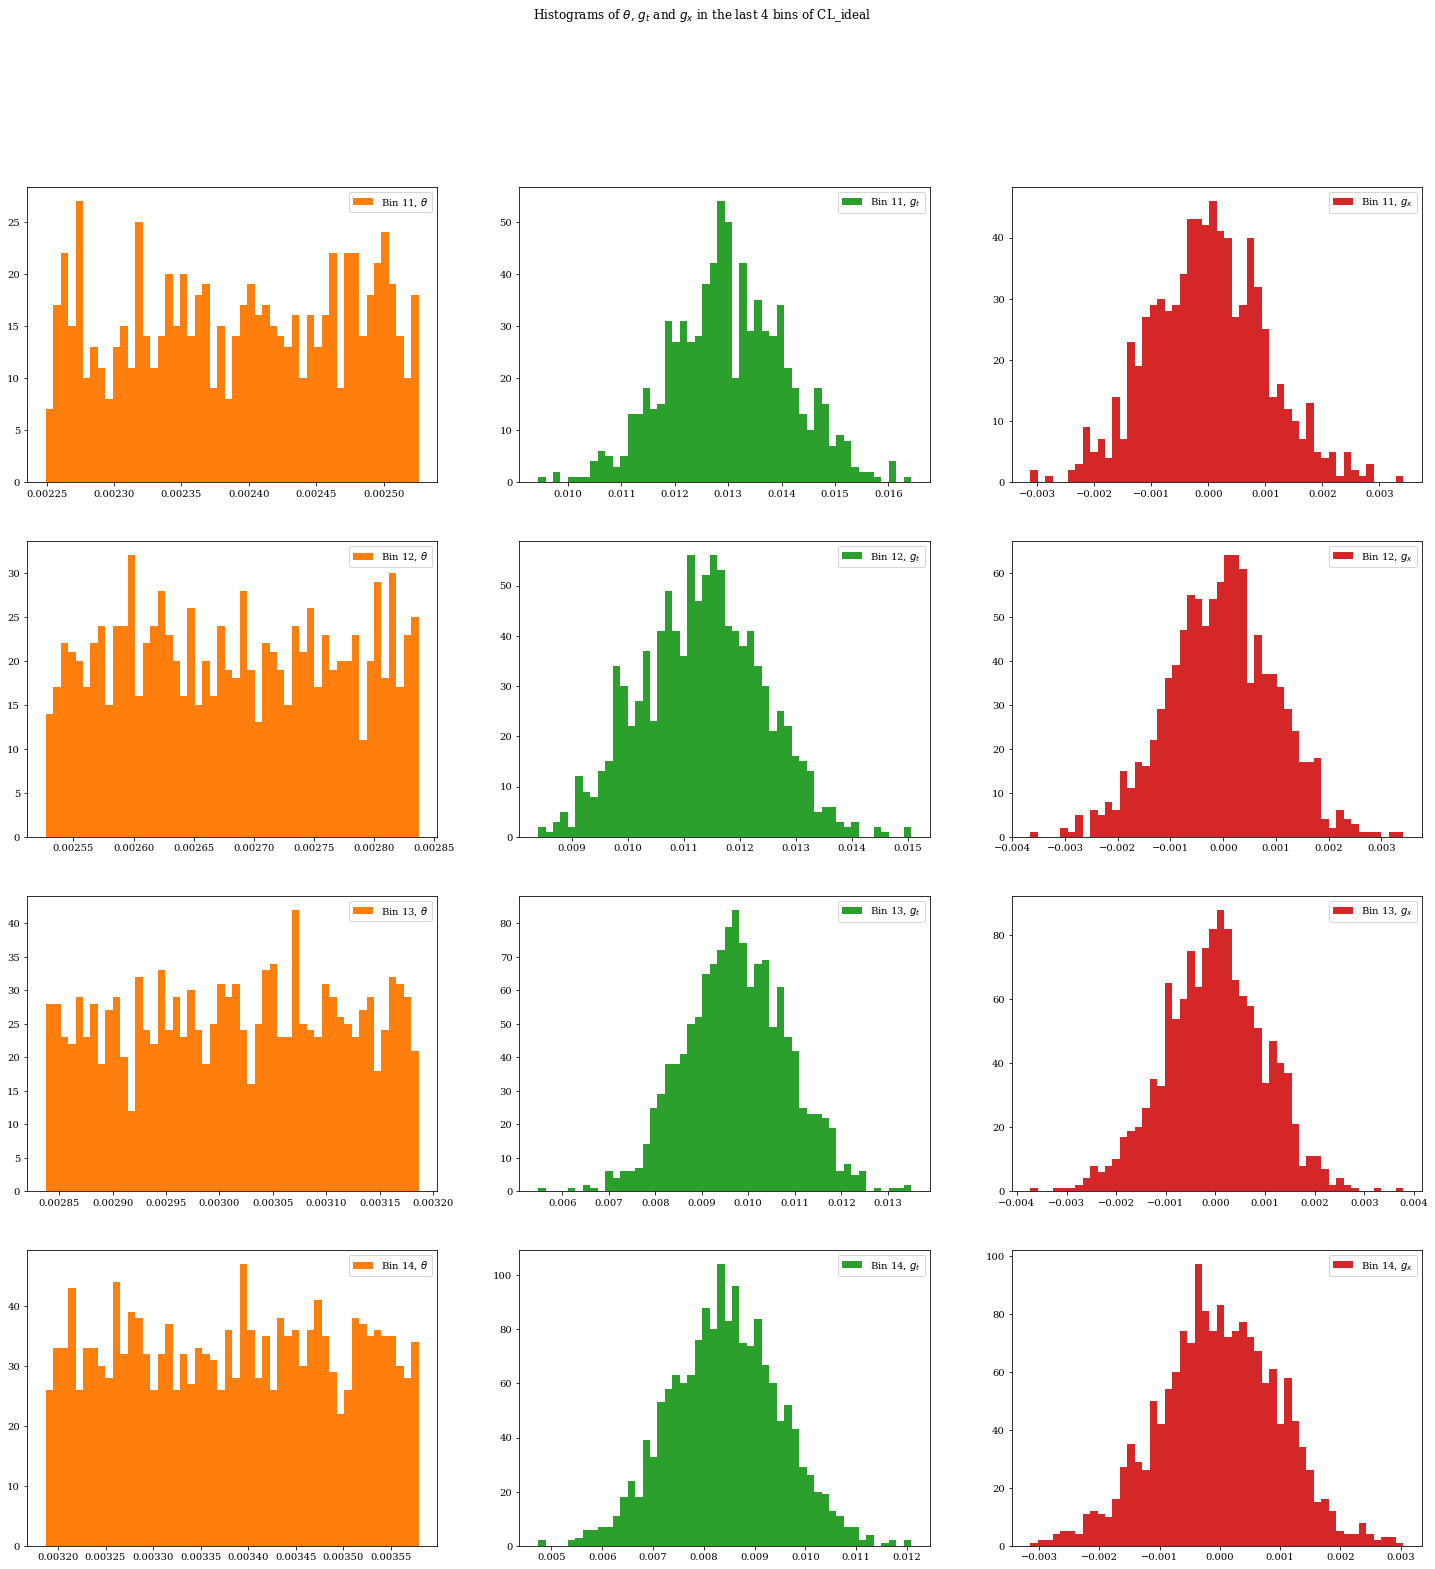

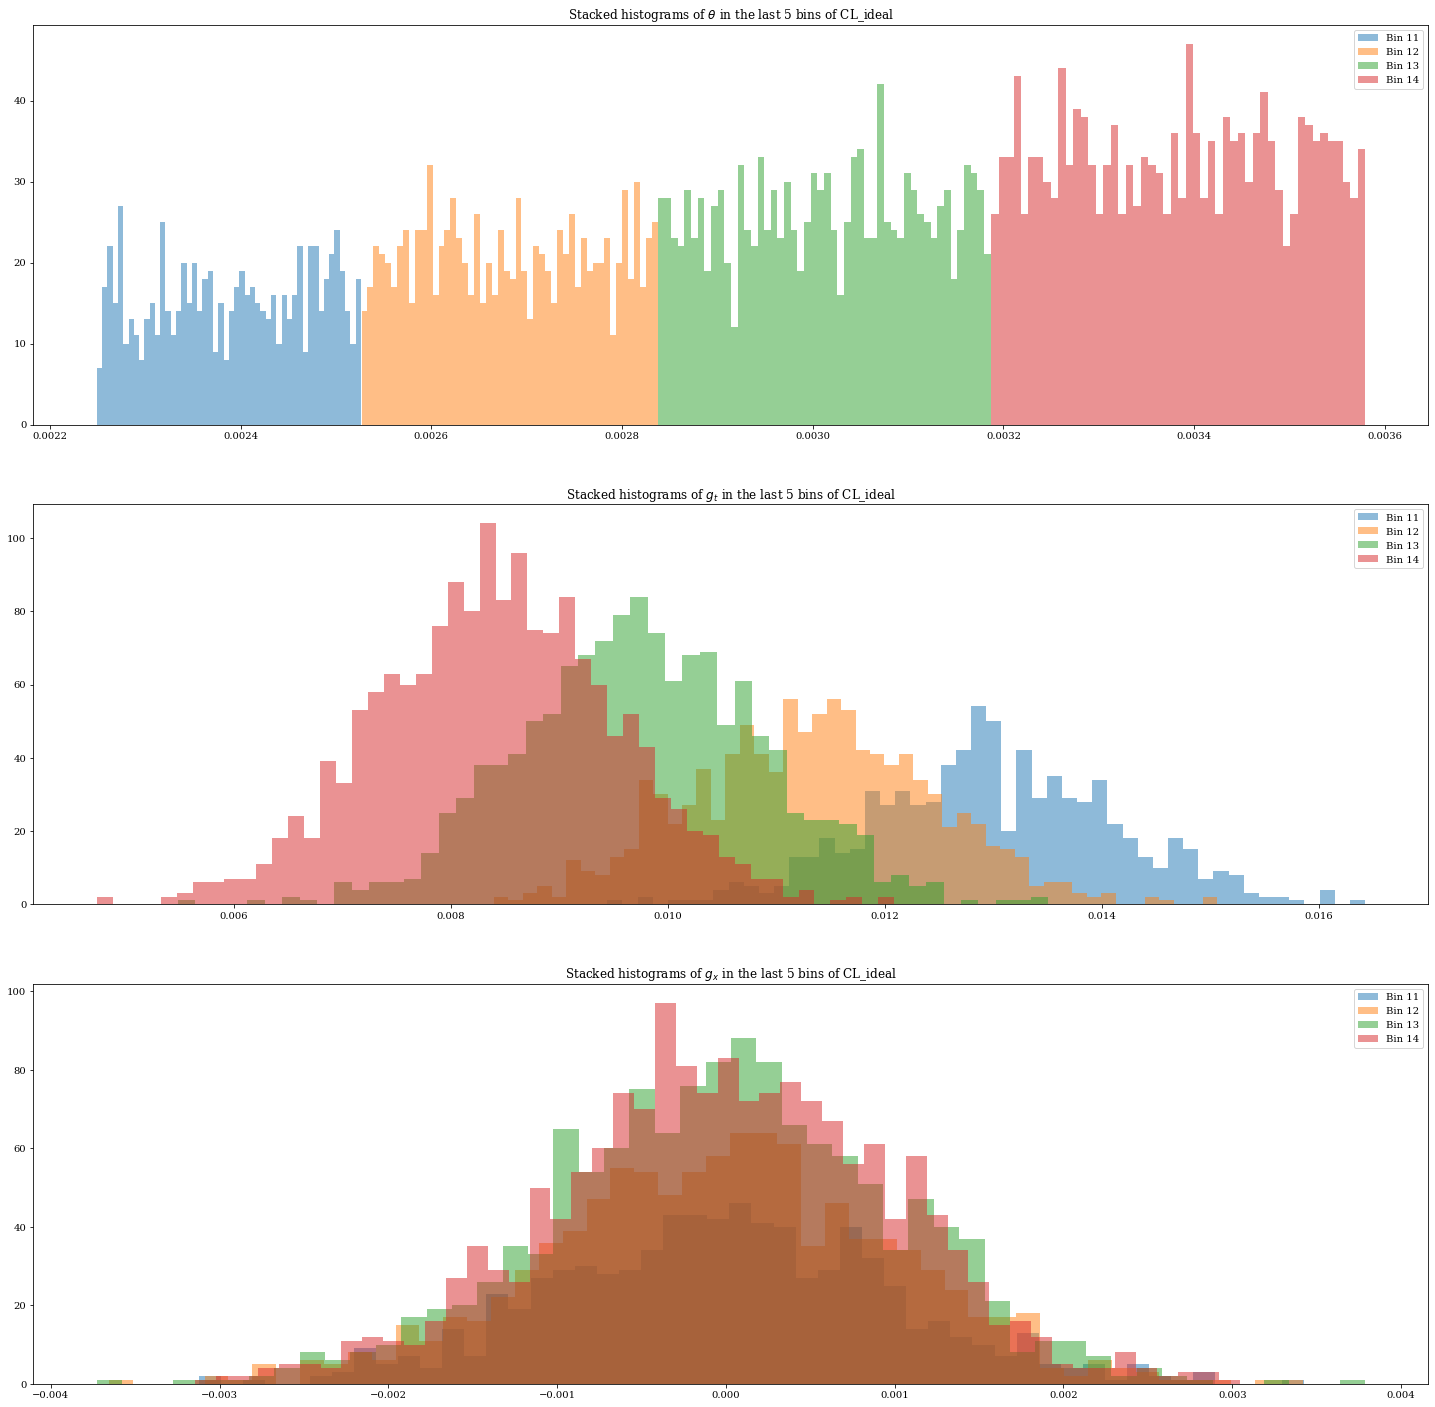

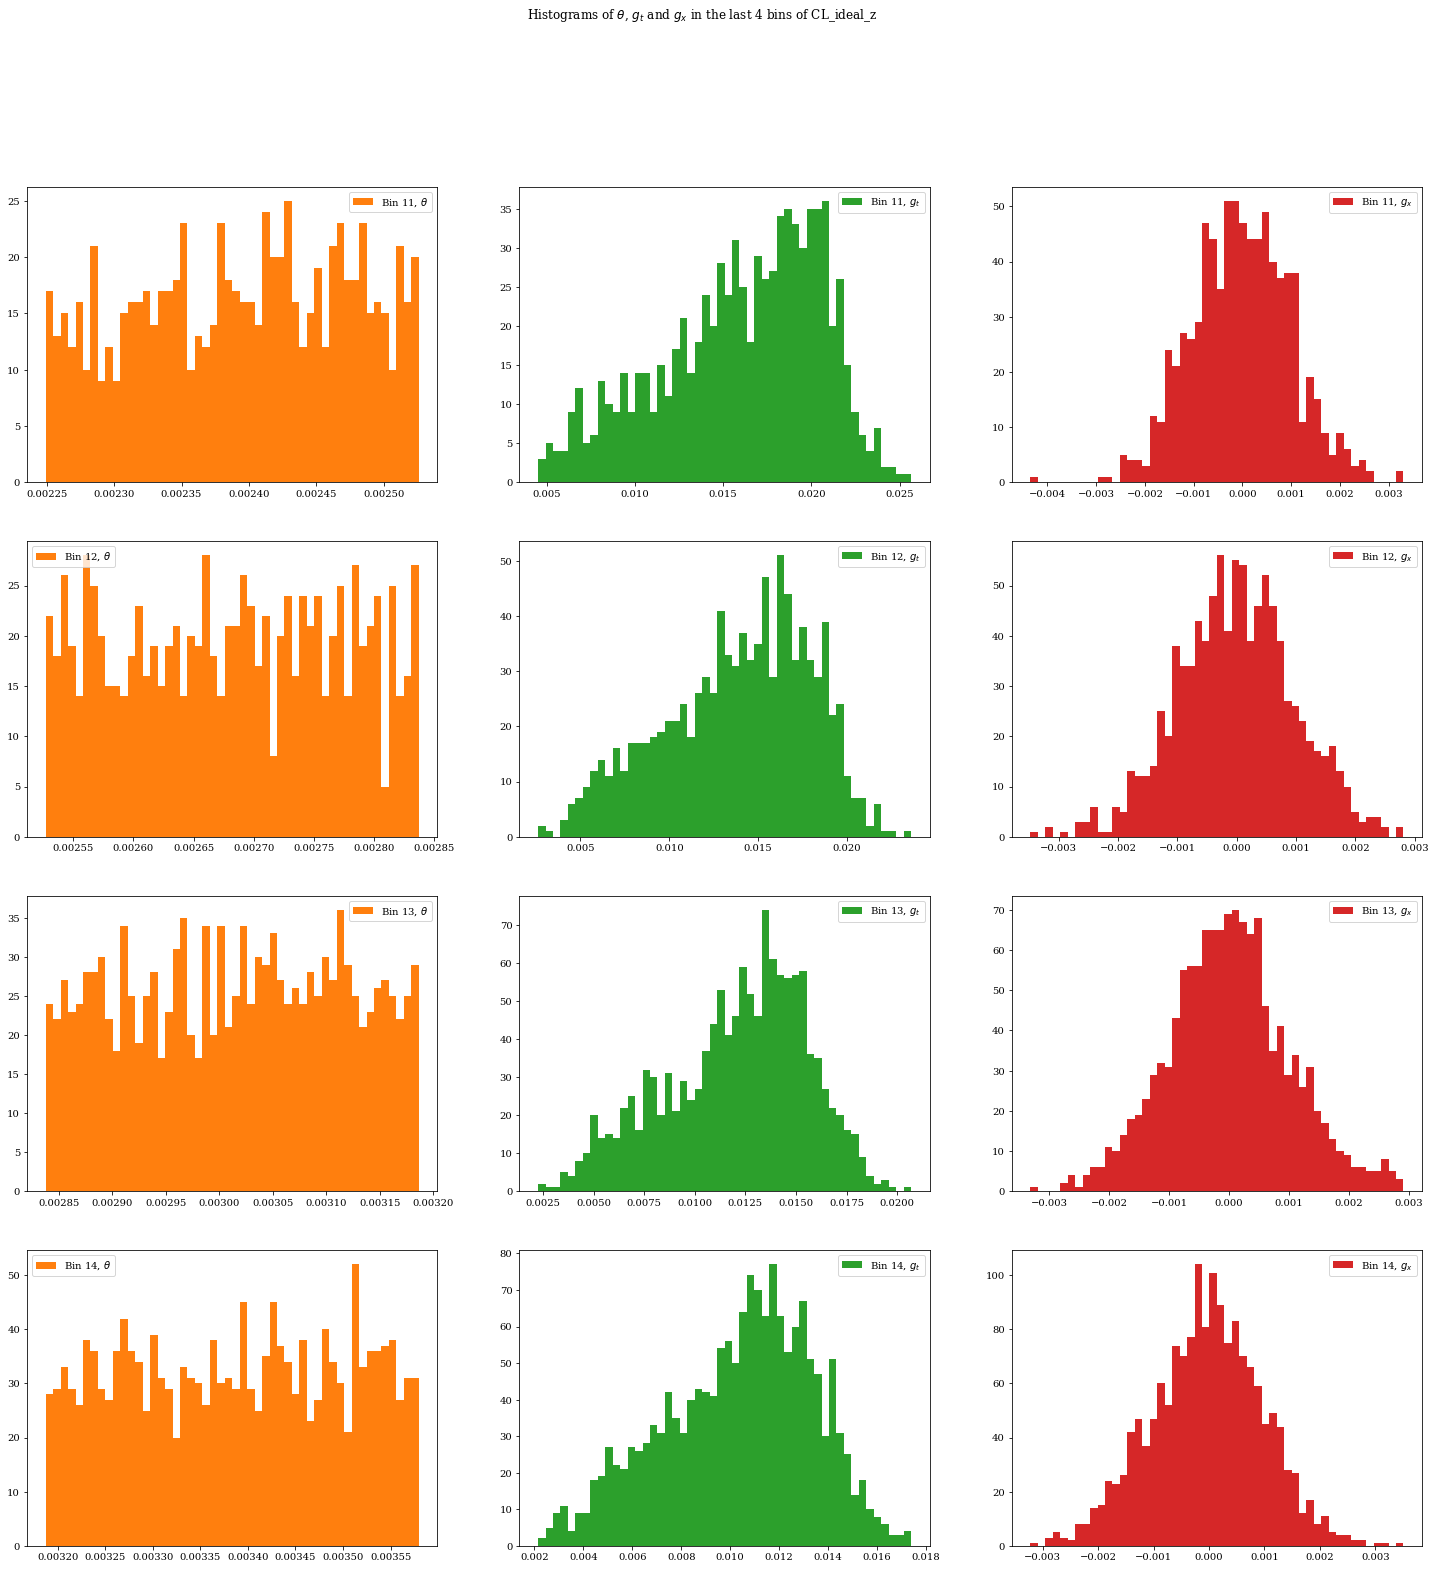

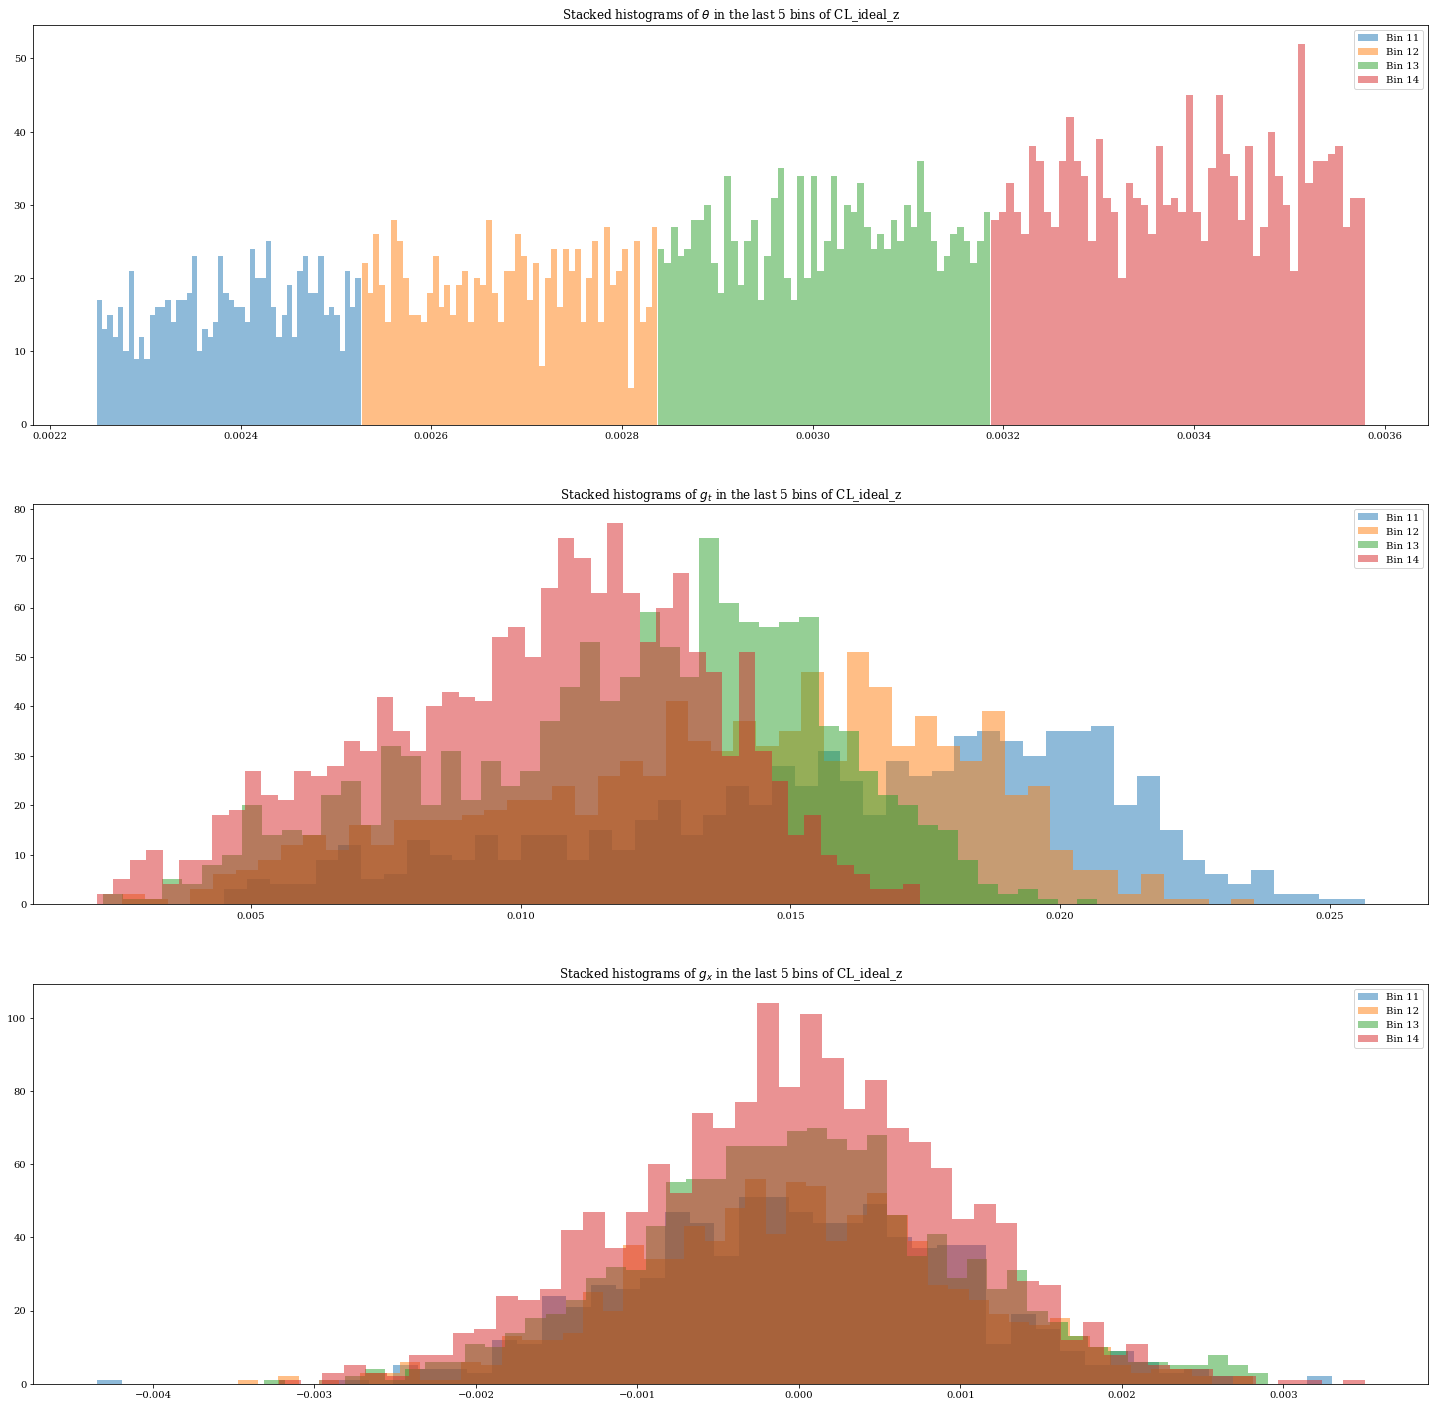

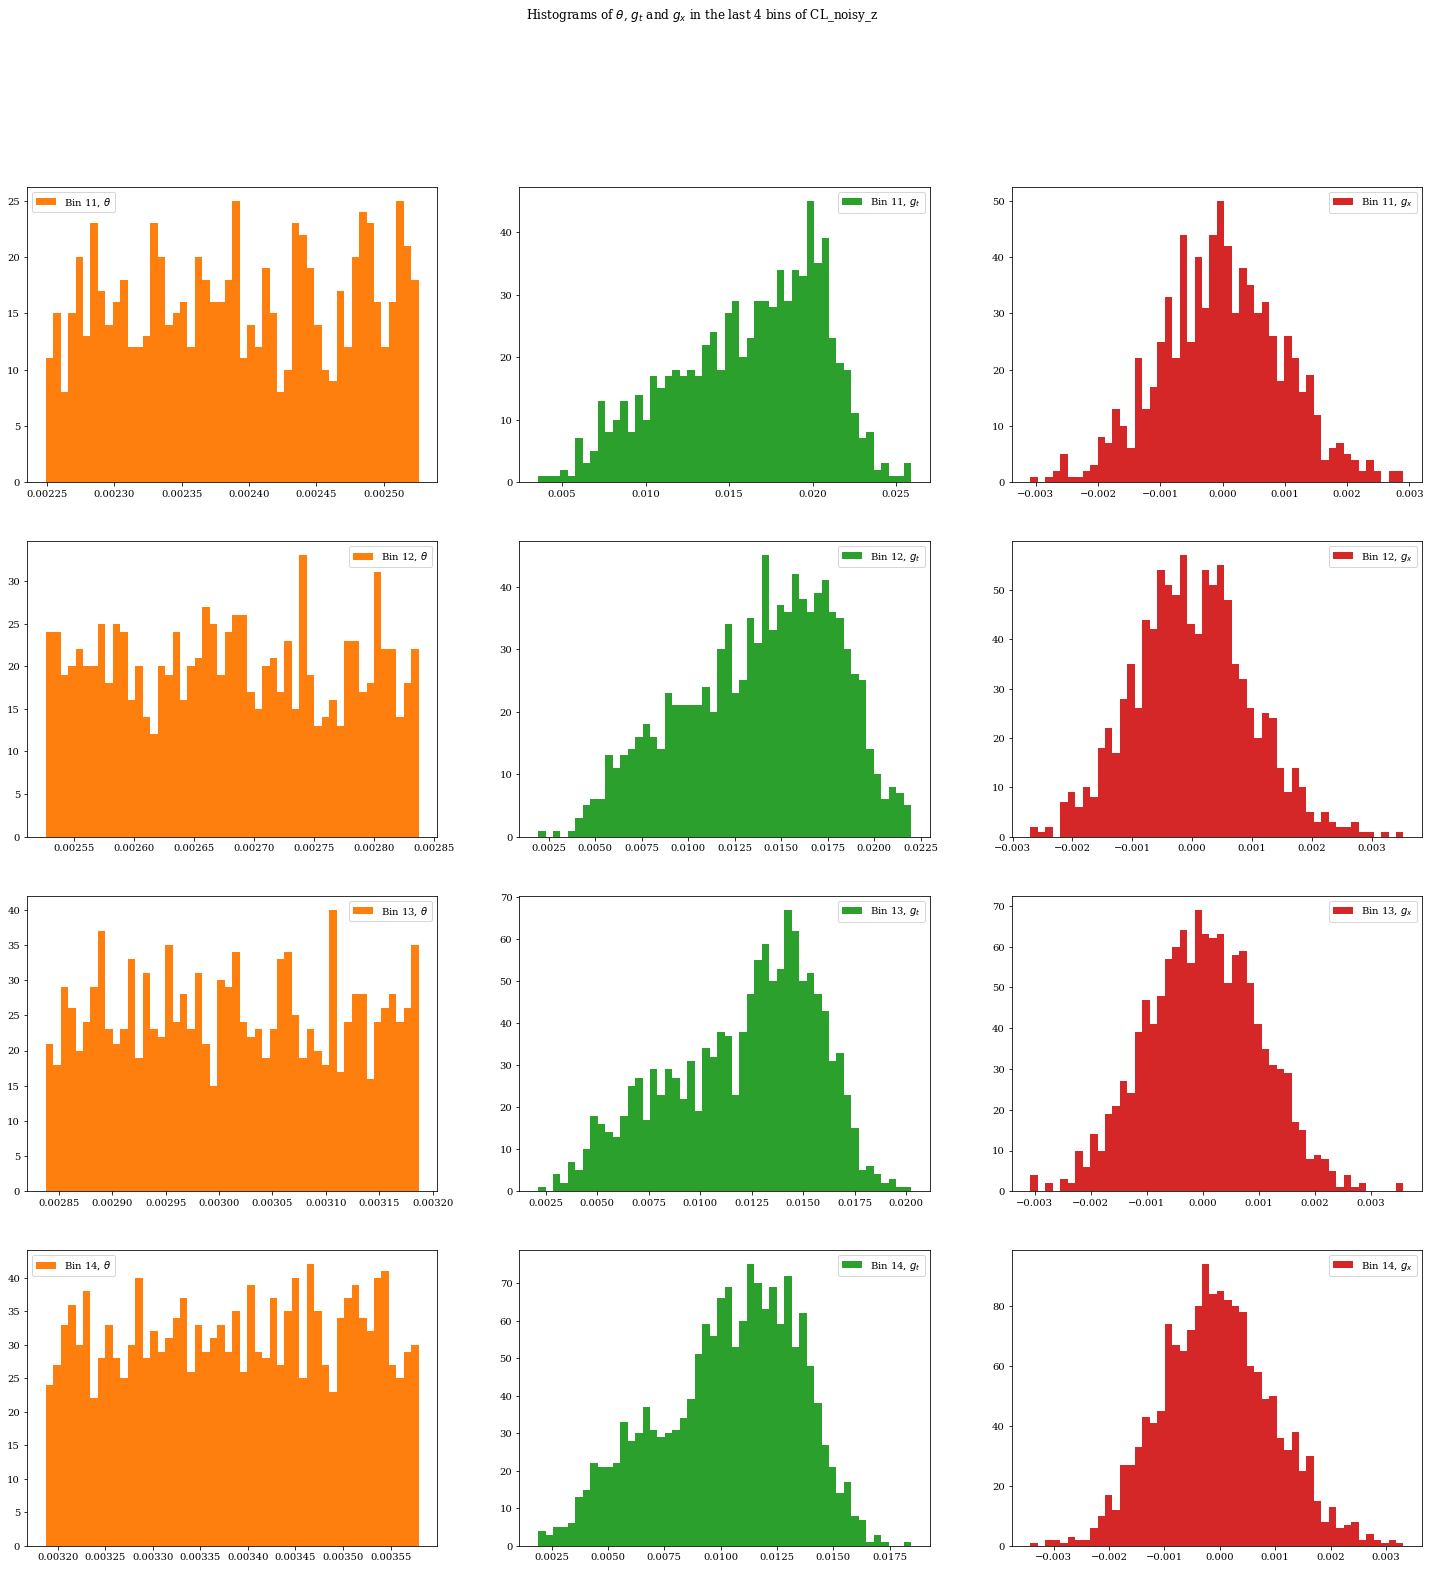

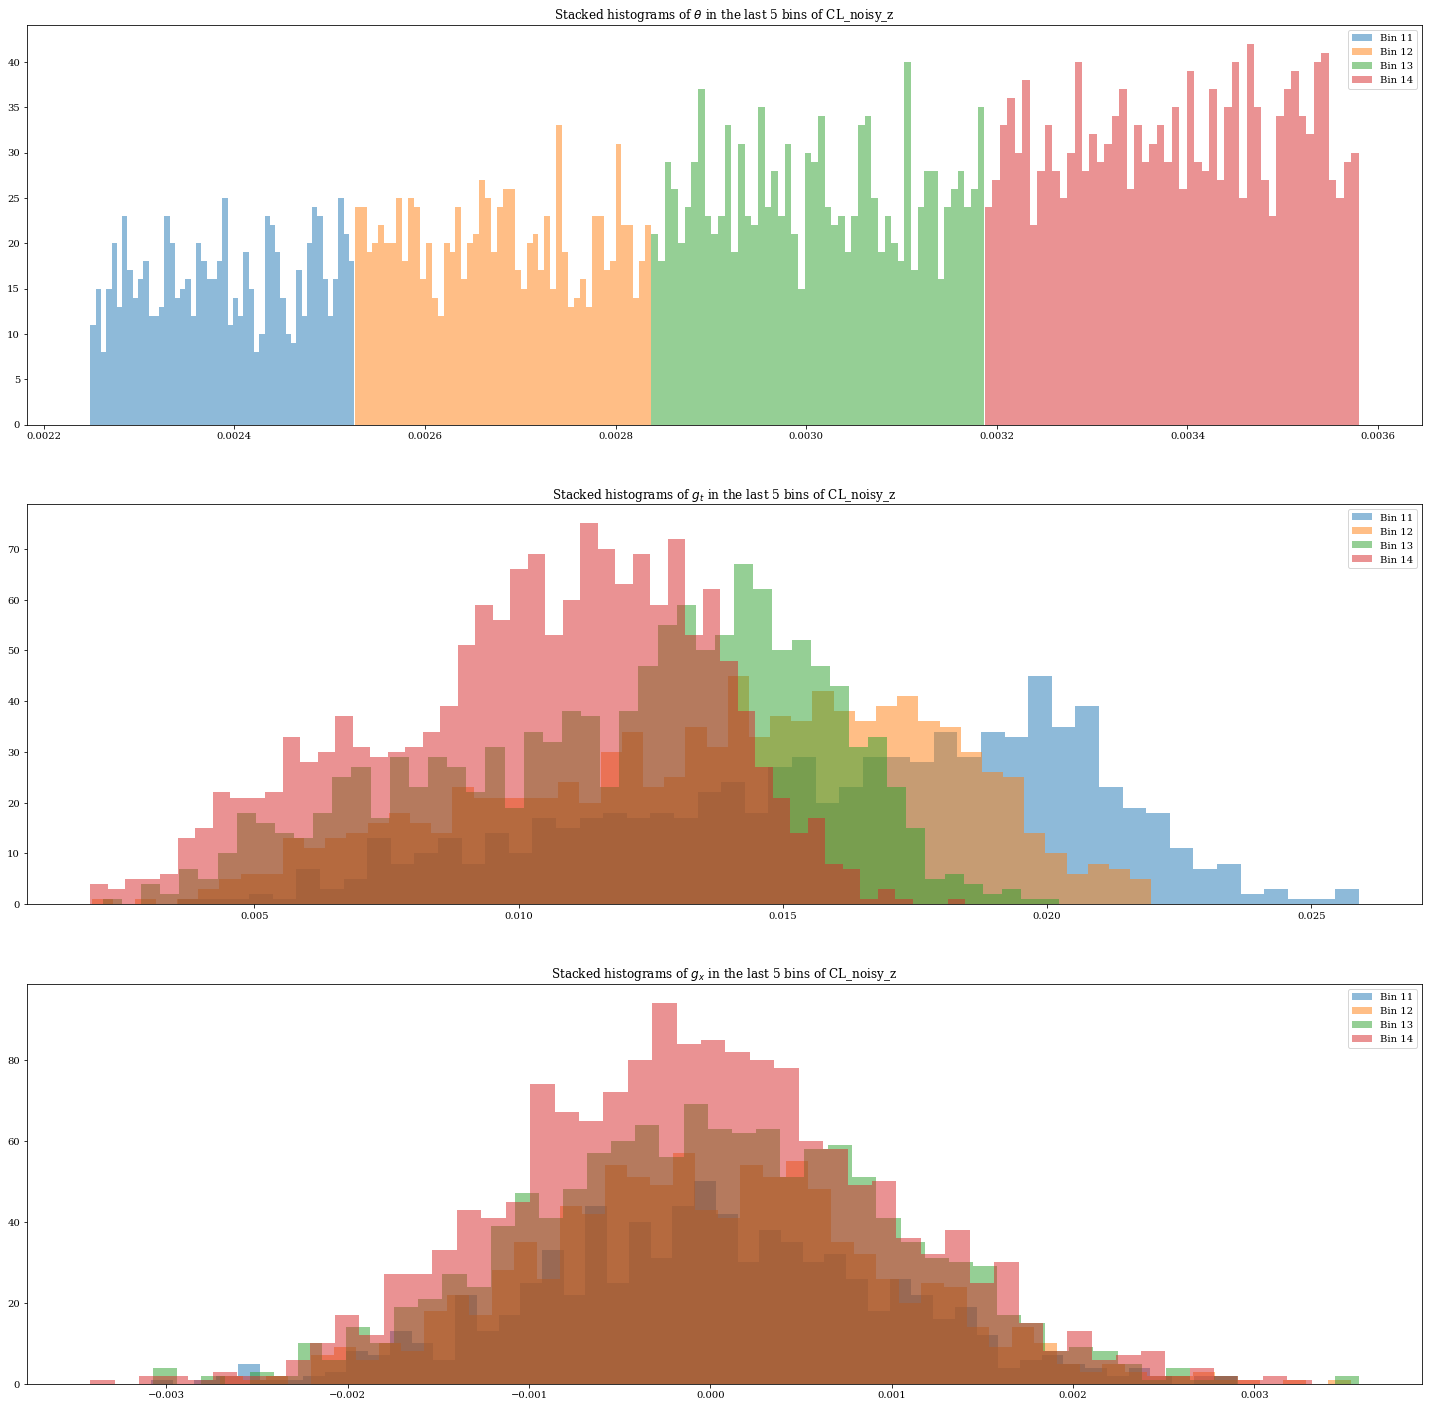

In [5]:
gc = [gc_ideal, gc_ideal_z, gc_noisy_z]

initial_bin = 11

dim = 25

for i in range(len(gc)):

    fig0, ax0 = plt.subplots(4, 3, figsize=(dim,dim), facecolor="white")
    fig1, ax1 = plt.subplots(3, 1, figsize=(dim,dim), facecolor="white")

    gc_theta = []
    gc_gt    = []
    gc_gx    = []

    for j in range(len(gc[i].profile)):
        gc_theta.append([gc[i].galcat['theta'][gal_id] for gal_id in gc[i].profile[j]['gal_id']])
        gc_gt.append([gc[i].galcat['et'][gal_id] for gal_id in gc[i].profile[j]['gal_id']])
        gc_gx.append([gc[i].galcat['ex'][gal_id] for gal_id in gc[i].profile[j]['gal_id']])

    for bin_i in range(initial_bin, len(gc[i].profile)):
        ax0[bin_i-initial_bin][0].hist(gc_theta[bin_i], bins=50, label=f'Bin {bin_i}, $\\theta$', color='tab:orange')
        ax0[bin_i-initial_bin][1].hist(gc_gt[bin_i], bins=50, label=f'Bin {bin_i}, $g_t$', color='tab:green')
        ax0[bin_i-initial_bin][2].hist(gc_gx[bin_i], bins=50, label=f'Bin {bin_i}, $g_x$', color='tab:red')

        ax0[bin_i-initial_bin][0].legend()
        ax0[bin_i-initial_bin][1].legend()
        ax0[bin_i-initial_bin][2].legend()

        ax1[0].hist(gc_theta[bin_i], bins=50, label=f"Bin {bin_i}", alpha=0.5)
        ax1[1].hist(gc_gt[bin_i], bins=50, label=f'Bin {bin_i}', alpha=0.5)
        ax1[2].hist(gc_gx[bin_i], bins=50, label=f'Bin {bin_i}', alpha=0.5)

        ax1[0].legend()
        ax1[1].legend()
        ax1[2].legend()

    fig0.suptitle(f'Histograms of $\\theta$, $g_t$ and $g_x$ in the last {len(gc[i].profile)-initial_bin} bins of {gc[i].unique_id}')

    ax1[0].set_title(f'Stacked histograms of $\\theta$ in the last 5 bins of {gc[i].unique_id}')
    ax1[1].set_title(f'Stacked histograms of $g_t$ in the last 5 bins of {gc[i].unique_id}')
    ax1[2].set_title(f'Stacked histograms of $g_x$ in the last 5 bins of {gc[i].unique_id}')

### Creating EPDF from data

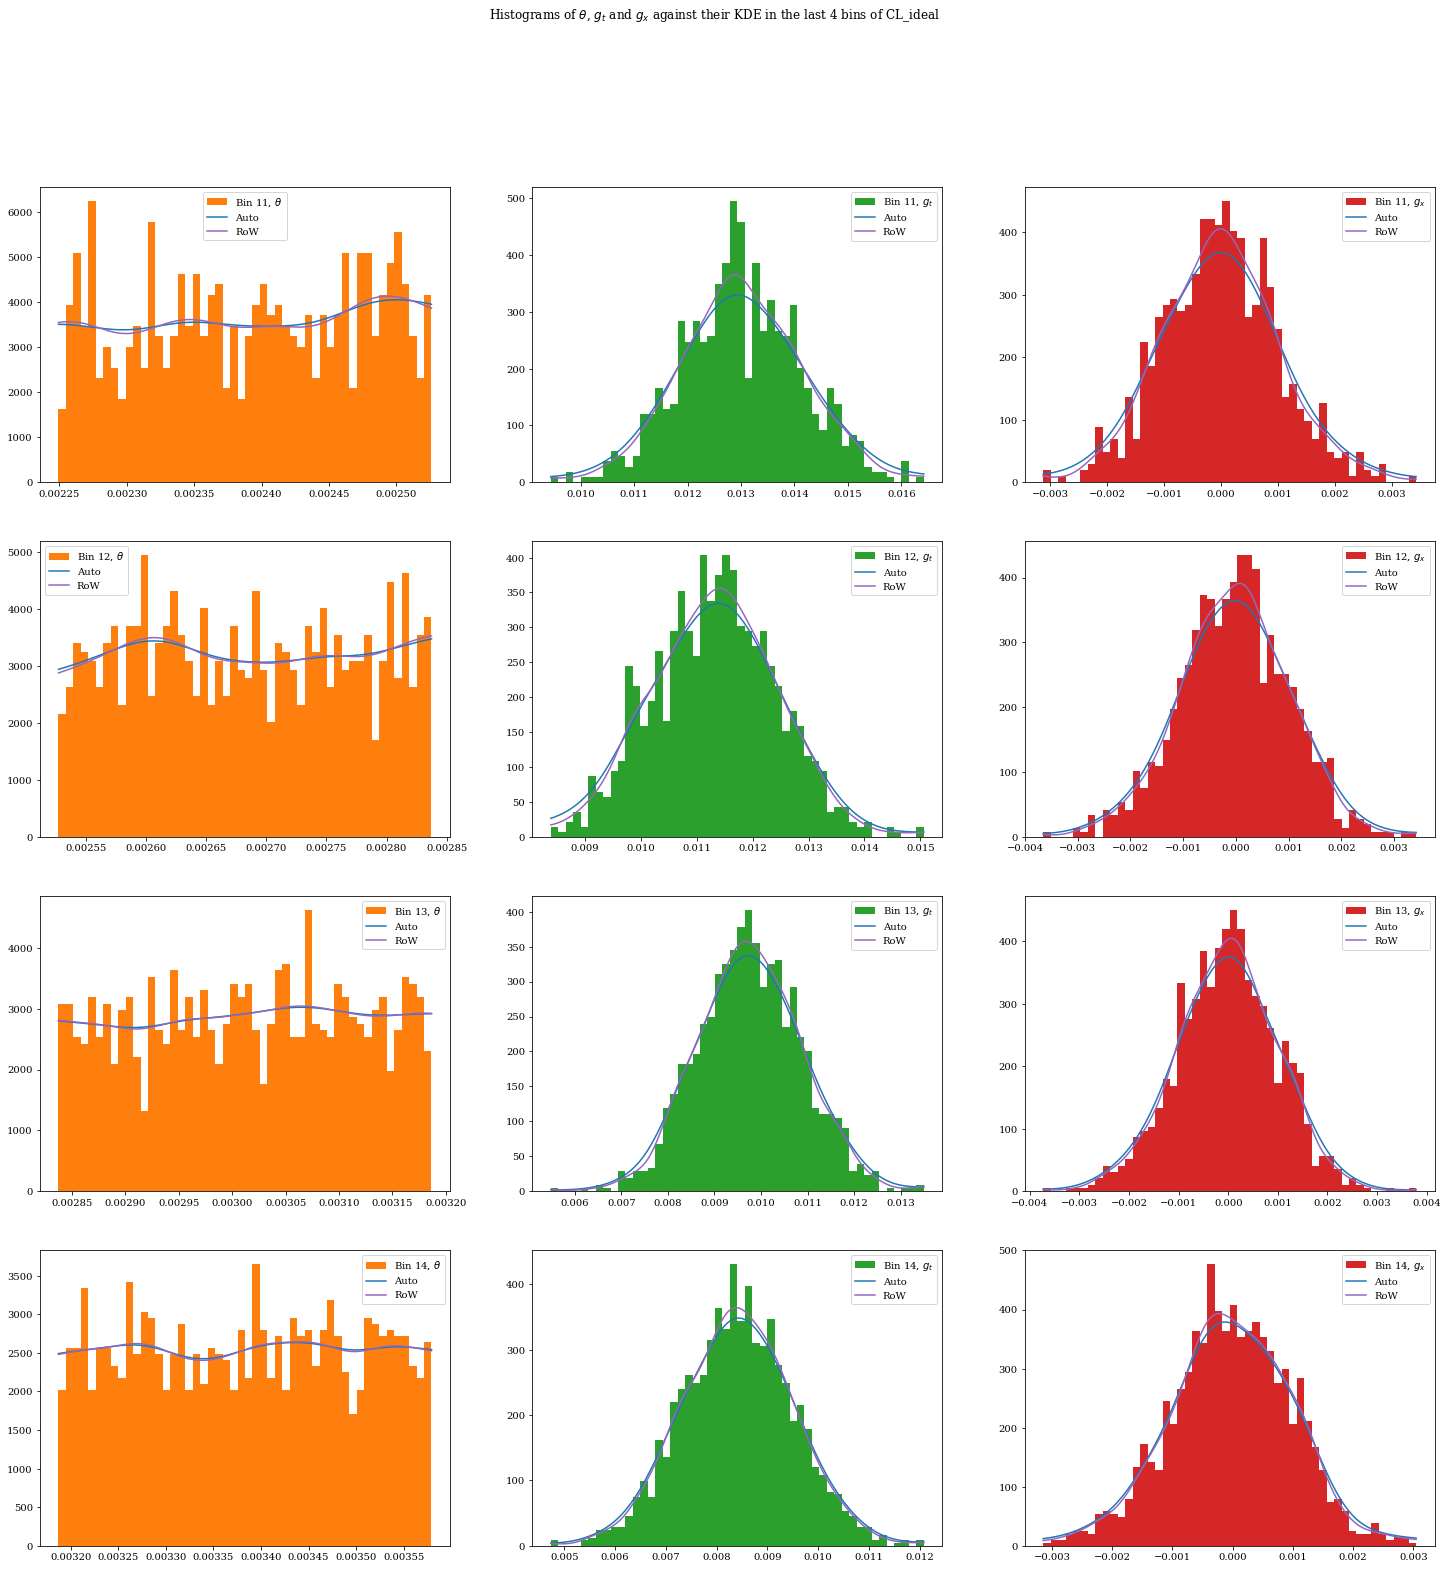

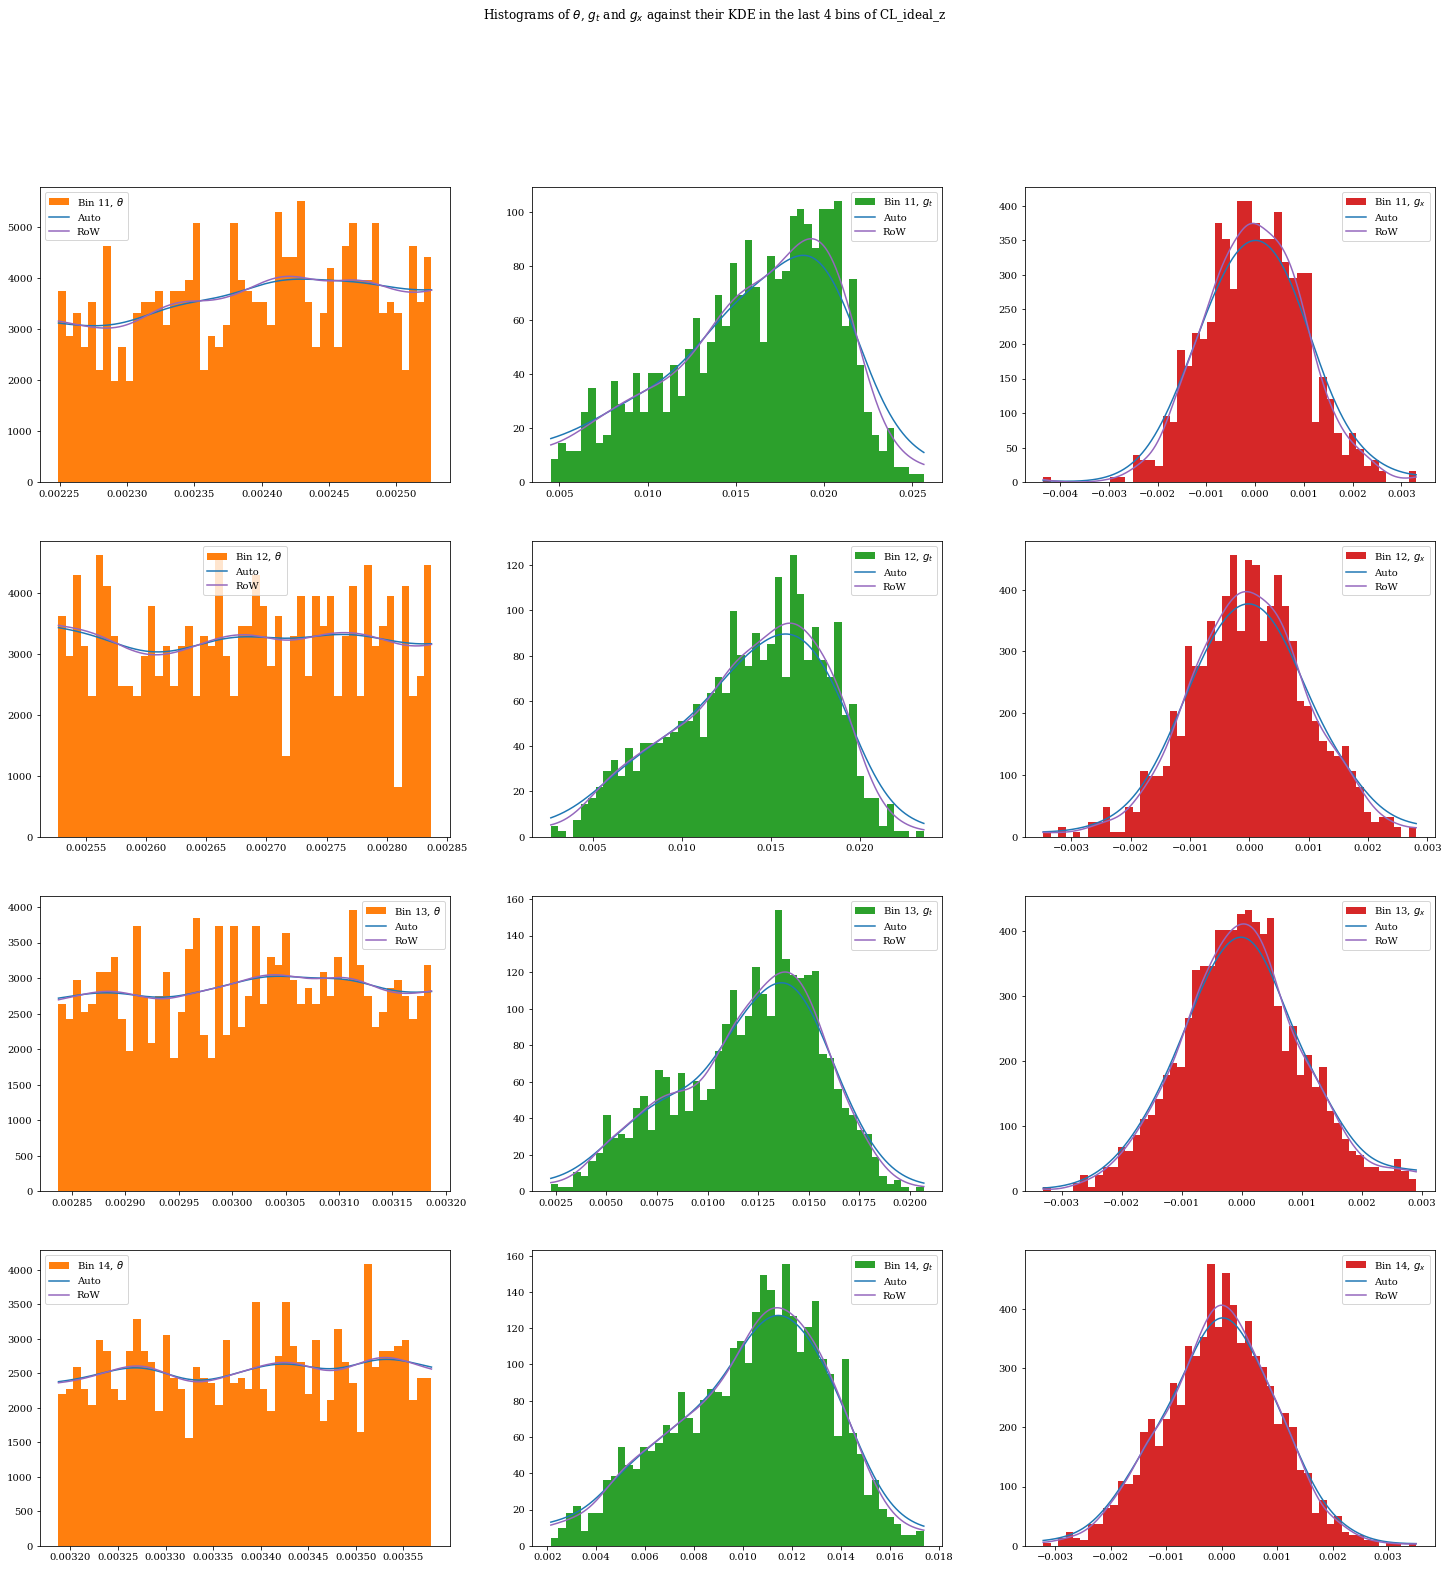

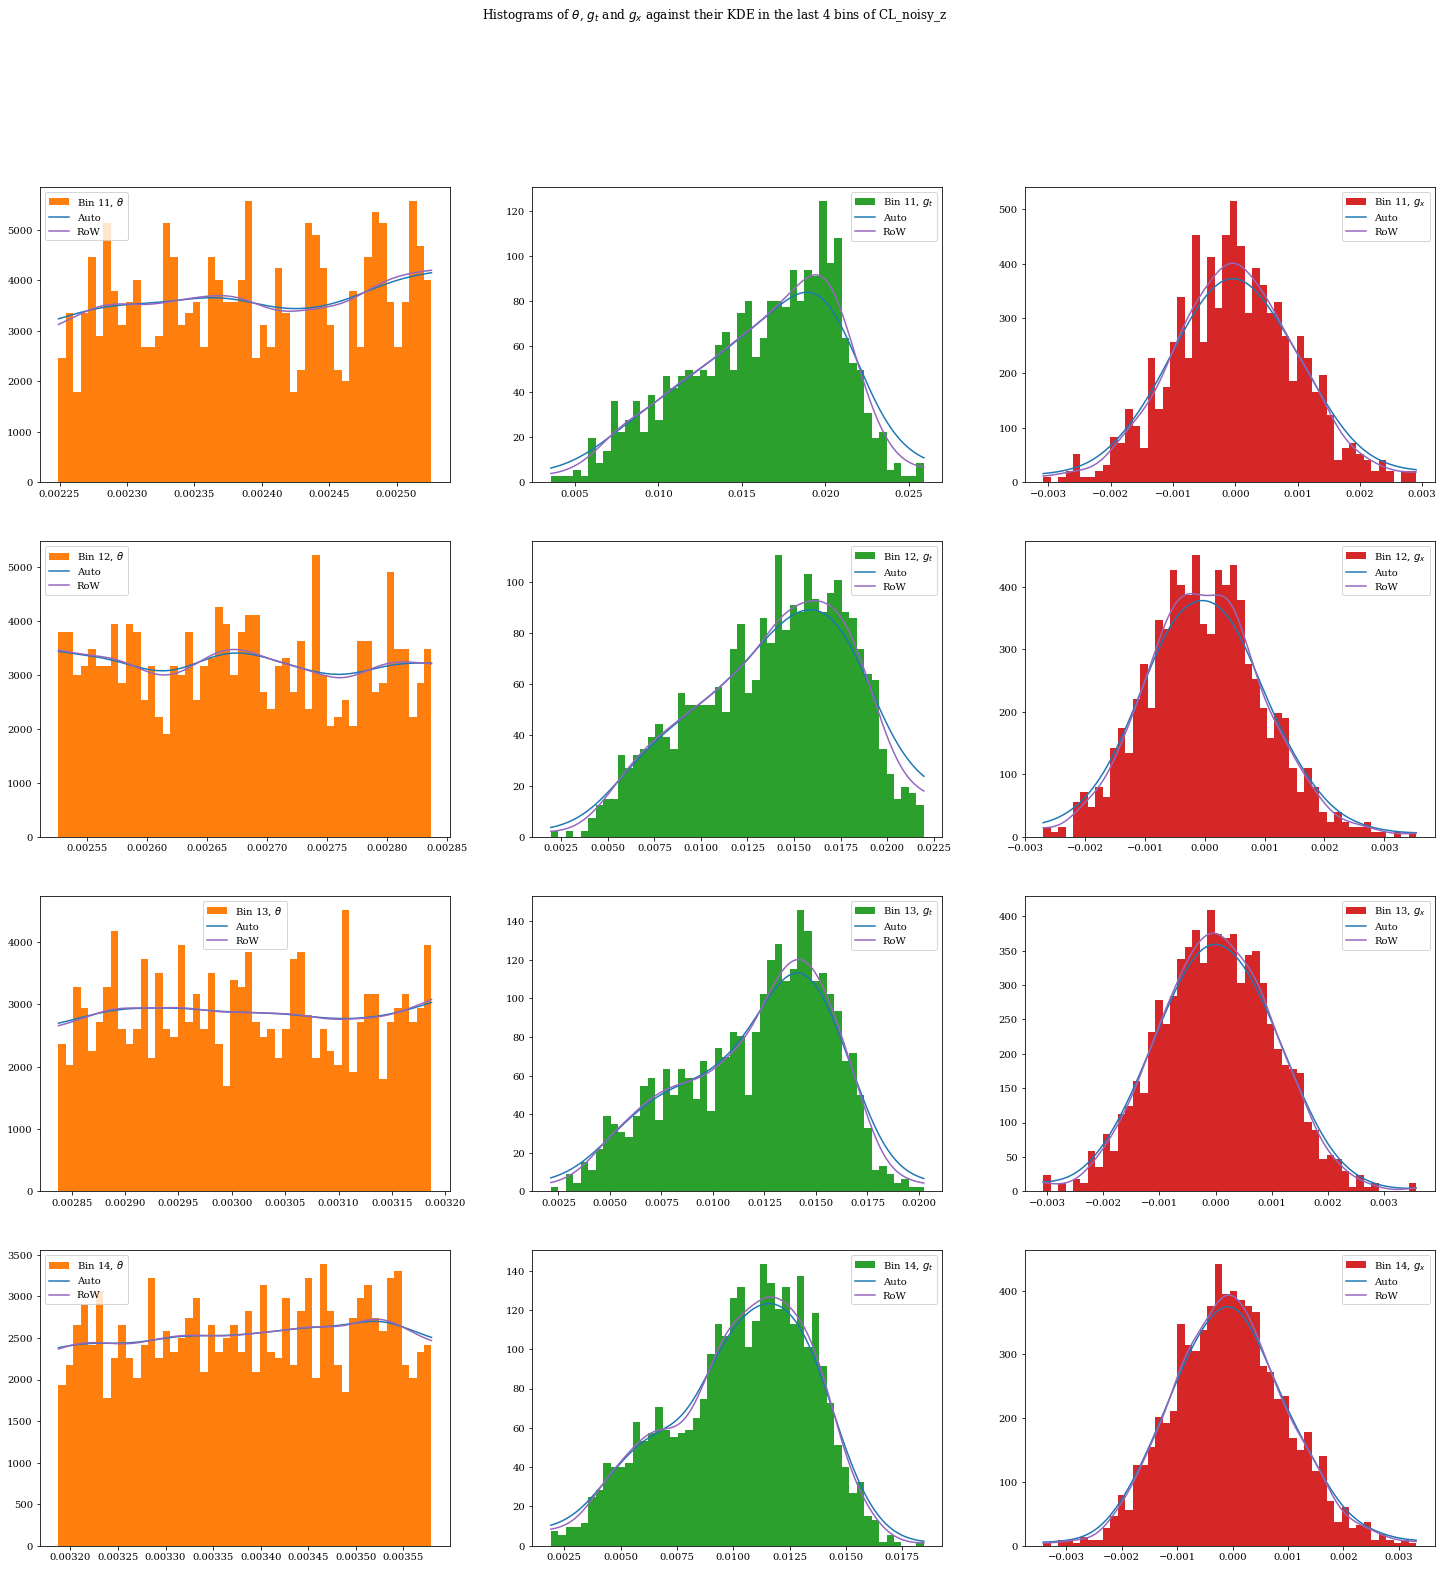

In [6]:
gc = [gc_ideal, gc_ideal_z, gc_noisy_z]

initial_bin = 11

dim = 25

for i in range(len(gc)):

    fig, ax = plt.subplots(4, 3, figsize=(dim,dim), facecolor="white")

    gc_theta = []
    gc_gt    = []
    gc_gx    = []

    for j in range(len(gc[i].profile)):

        gc_theta.append([gc[i].galcat['theta'][gal_id] for gal_id in gc[i].profile[j]['gal_id']])
        gc_gt.append([gc[i].galcat['et'][gal_id] for gal_id in gc[i].profile[j]['gal_id']])
        gc_gx.append([gc[i].galcat['ex'][gal_id] for gal_id in gc[i].profile[j]['gal_id']])

    for bin_i in range(initial_bin, len(gc[i].profile)):

        ax[bin_i-initial_bin][0].hist(gc_theta[bin_i], bins=50, density=True, label=f'Bin {bin_i}, $\\theta$', color='tab:orange')
        theta_kde = Ncm.StatsDist1dEPDF.new_full (2000, Ncm.StatsDist1dEPDFBw.AUTO, 1, 0.001)
        theta_kde_rot = Ncm.StatsDist1dEPDF.new_full (2000, Ncm.StatsDist1dEPDFBw.ROT, 1, 0.001)

        for th in gc_theta[bin_i]:
            theta_kde.add_obs(th)
            theta_kde_rot.add_obs(th)

        theta_kde.prepare()
        theta_kde_rot.prepare()
        x = np.linspace(min(gc_theta[bin_i]), max(gc_theta[bin_i]), num=1000)
        y = [theta_kde.eval_p(xi) for xi in x]
        z = [theta_kde_rot.eval_p(xi) for xi in x]
        ax[bin_i-initial_bin][0].plot(x, y, color='tab:blue', label='Auto')
        ax[bin_i-initial_bin][0].plot(x, z, color='tab:purple', label='RoW')


        ax[bin_i-initial_bin][1].hist(gc_gt[bin_i], bins=50, density=True, label=f'Bin {bin_i}, $g_t$', color='tab:green')
        gt_kde = Ncm.StatsDist1dEPDF.new_full (2000, Ncm.StatsDist1dEPDFBw.AUTO, 1, 0.001)
        gt_kde_rot = Ncm.StatsDist1dEPDF.new_full (2000, Ncm.StatsDist1dEPDFBw.ROT, 1, 0.001)

        for gt in gc_gt[bin_i]:
            gt_kde.add_obs(gt)
            gt_kde_rot.add_obs(gt)

        gt_kde.prepare()
        gt_kde_rot.prepare()
        x = np.linspace(min(gc_gt[bin_i]), max(gc_gt[bin_i]), num=1000)
        y = [gt_kde.eval_p(xi) for xi in x]
        z = [gt_kde_rot.eval_p(xi) for xi in x]
        ax[bin_i-initial_bin][1].plot(x, y, color='tab:blue', label='Auto')
        ax[bin_i-initial_bin][1].plot(x, z, color='tab:purple', label='RoW')


        ax[bin_i-initial_bin][2].hist(gc_gx[bin_i], bins=50, density=True, label=f'Bin {bin_i}, $g_x$', color='tab:red')
        gx_kde = Ncm.StatsDist1dEPDF.new_full (2000, Ncm.StatsDist1dEPDFBw.AUTO, 1, 0.001)
        gx_kde_rot = Ncm.StatsDist1dEPDF.new_full (2000, Ncm.StatsDist1dEPDFBw.ROT, 1, 0.001)

        for gx in gc_gx[bin_i]:
            gx_kde.add_obs(gx)
            gx_kde_rot.add_obs(gx)

        gx_kde.prepare()
        gx_kde_rot.prepare()
        x = np.linspace(min(gc_gx[bin_i]), max(gc_gx[bin_i]), num=1000)
        y = [gx_kde.eval_p(xi) for xi in x]
        z = [gx_kde_rot.eval_p(xi) for xi in x]
        ax[bin_i-initial_bin][2].plot(x, y, color='tab:blue', label='Auto')
        ax[bin_i-initial_bin][2].plot(x, z, color='tab:purple', label='RoW')

        ax[bin_i-initial_bin][0].legend()
        ax[bin_i-initial_bin][1].legend()
        ax[bin_i-initial_bin][2].legend()

    fig.suptitle(f'Histograms of $\\theta$, $g_t$ and $g_x$ against their KDE in the last {len(gc[i].profile)-initial_bin} bins of {gc[i].unique_id}')



### Performing Komolgorov-Smirnov test

/tmp/ipykernel_30248/48421805.py:110: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax[i][0].set_ylim(0,1)
/tmp/ipykernel_30248/48421805.py:119: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax[i][1].set_ylim(0,1)
/tmp/ipykernel_30248/48421805.py:110: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax[i][0].set_ylim(0,1)
/tmp/ipykernel_30248/48421805.py:119: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax[i][1].set_ylim(0,1)
/tmp/ipykernel_30248/48421805.py:110: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax[i][0].set_ylim(0,1)
/tmp/ipykernel_30248/48421805.py:119: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.

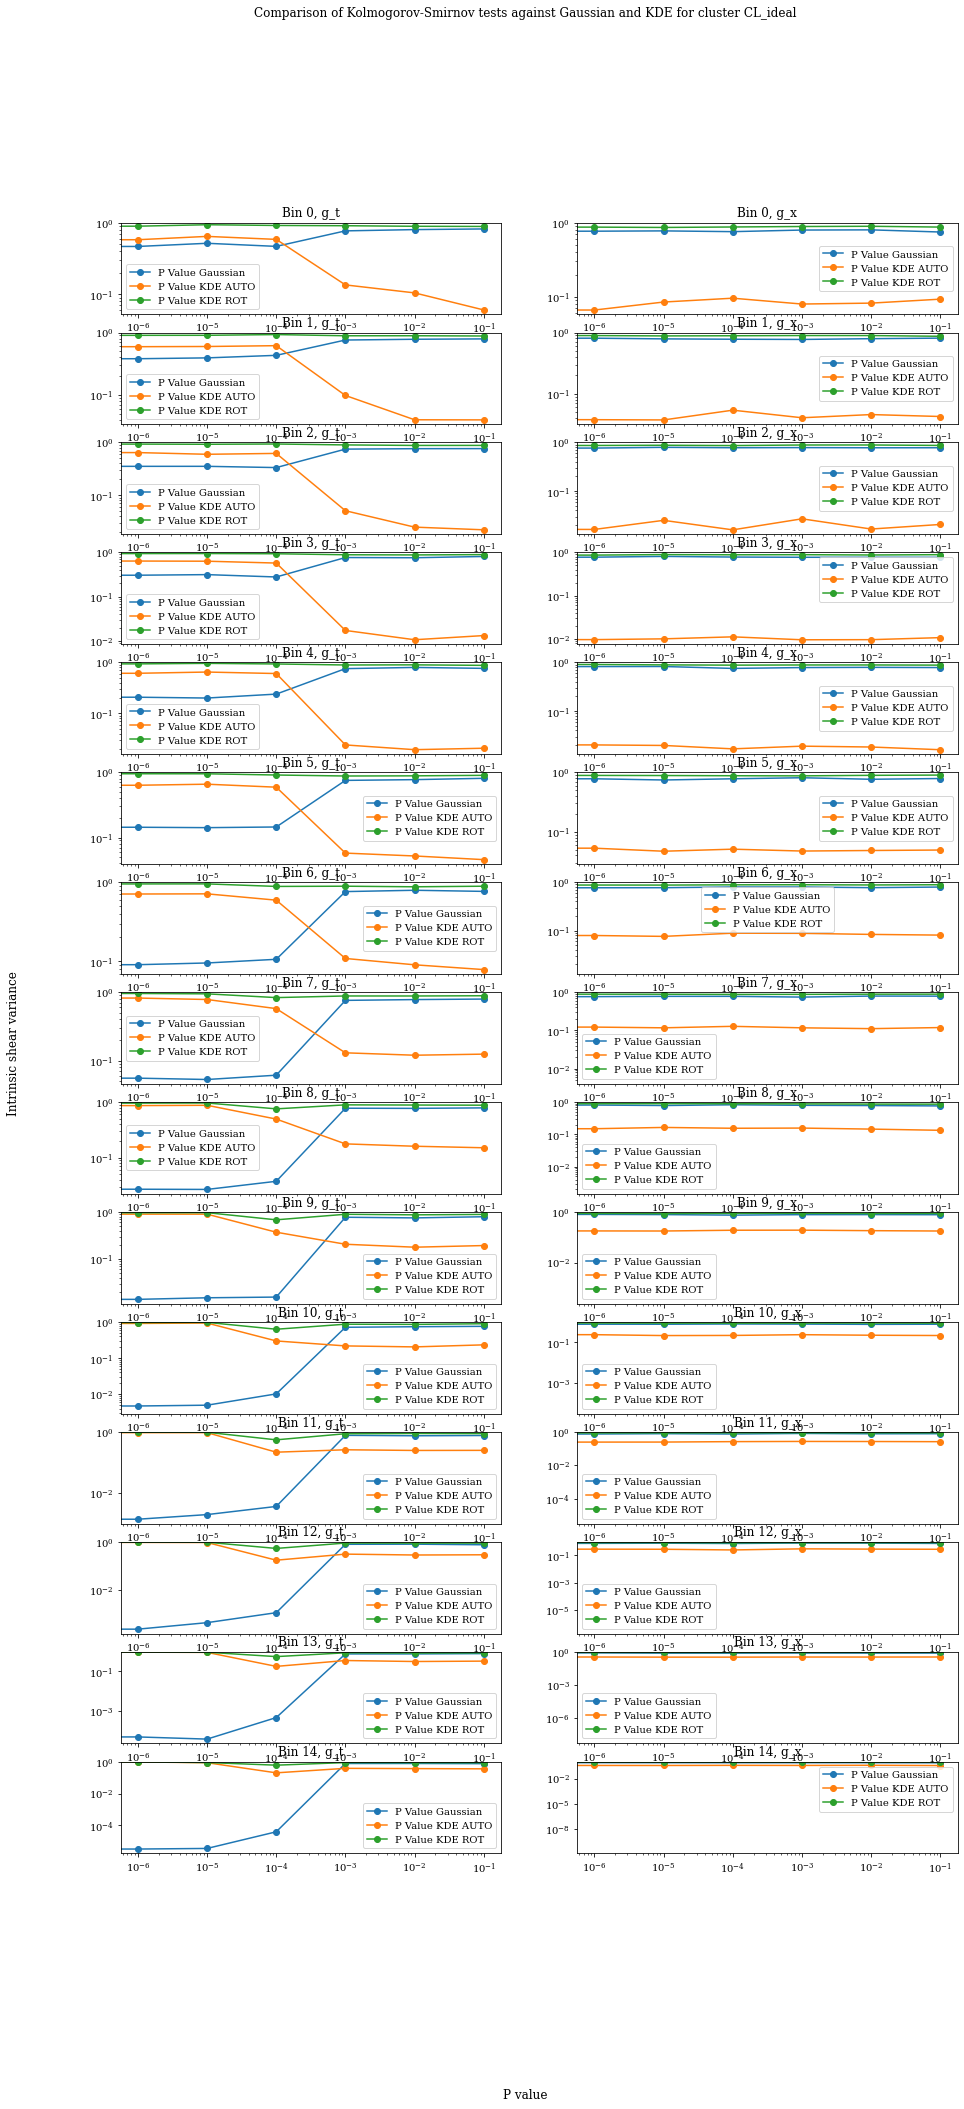

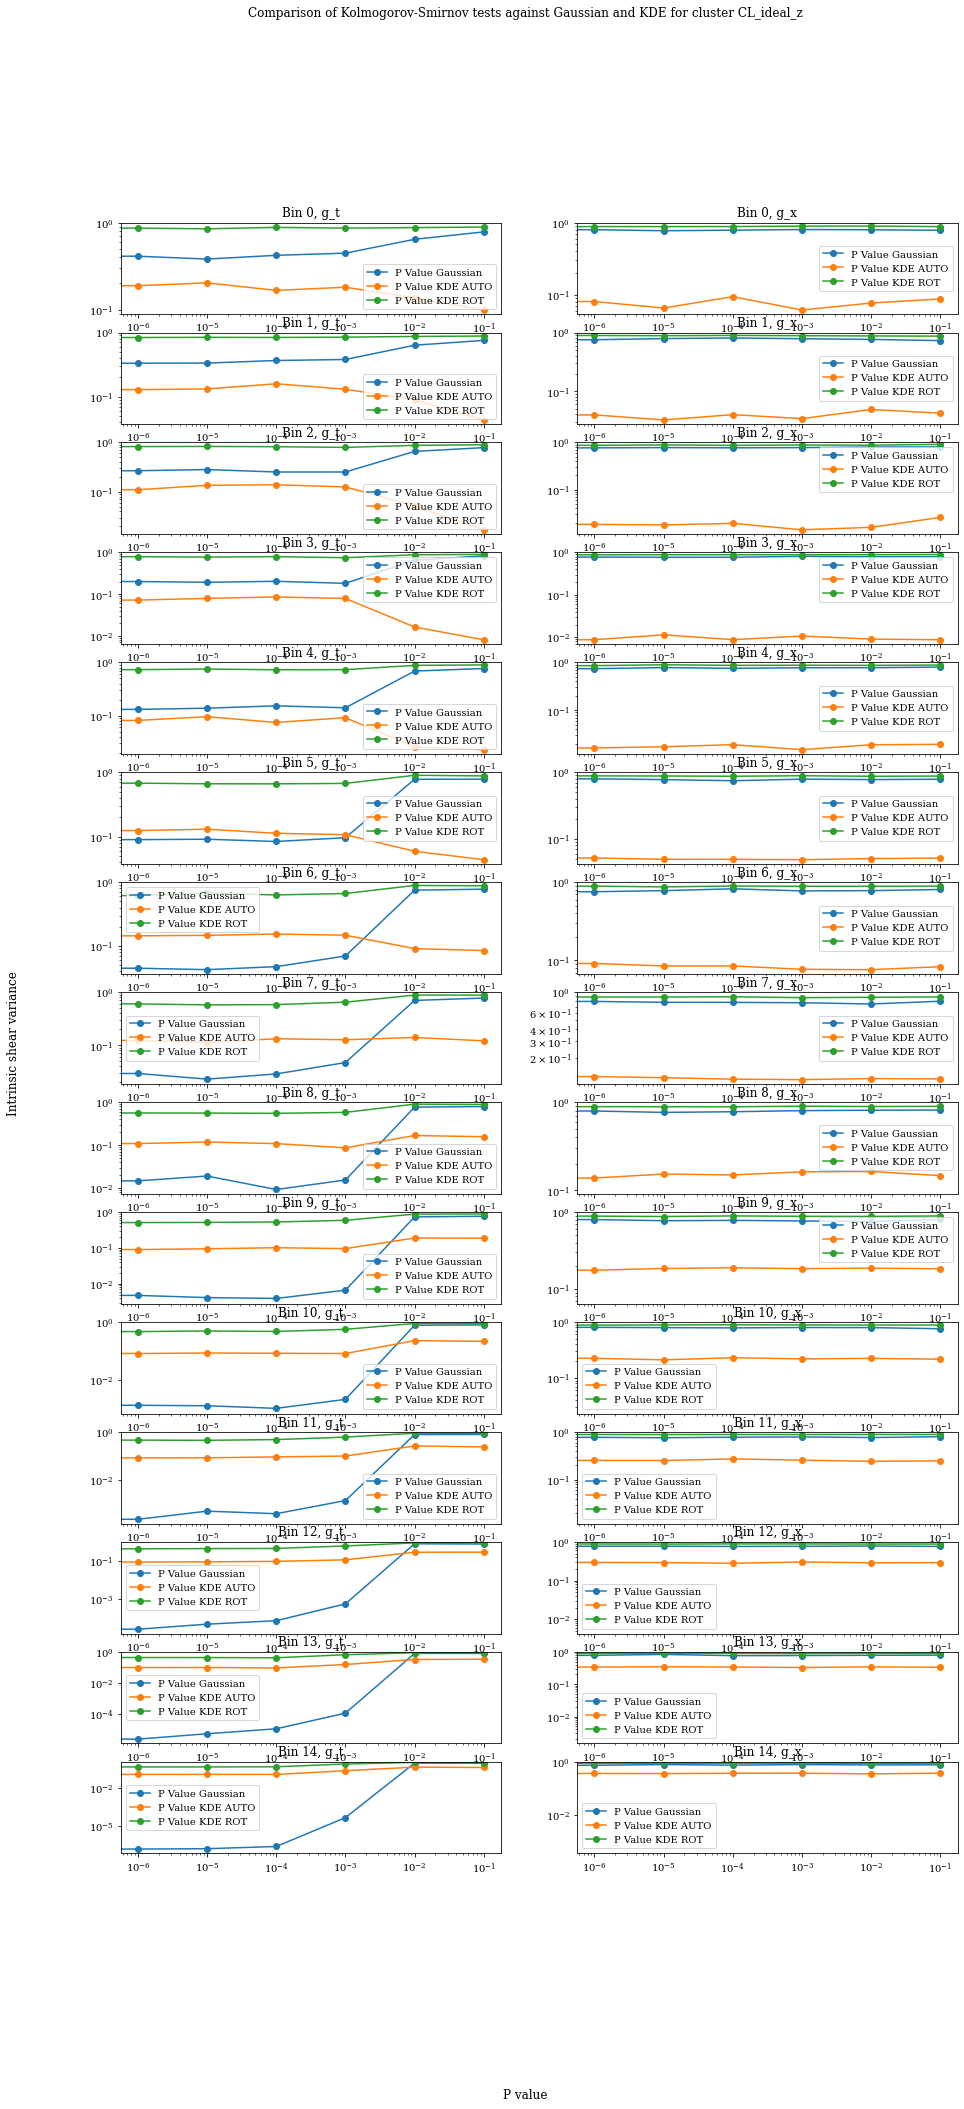

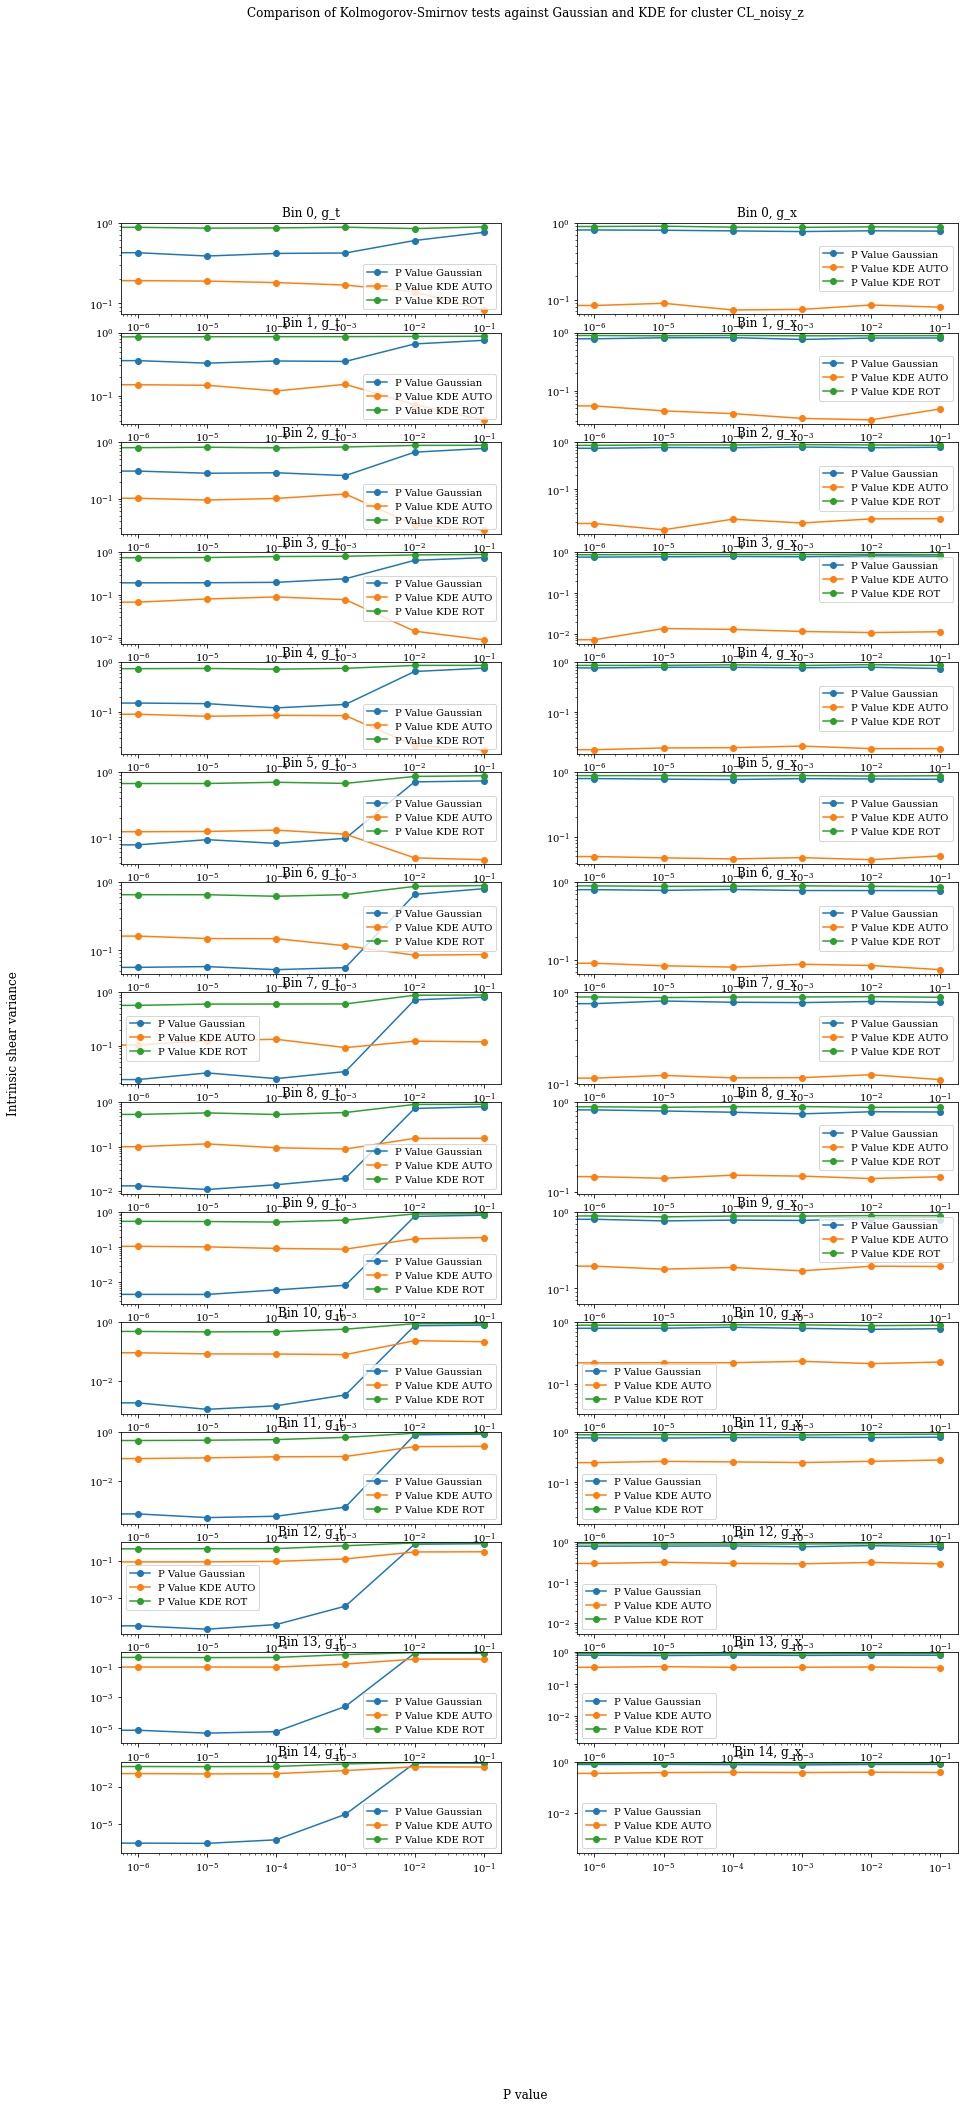

In [7]:
shapenoise = [None, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
clusters   = [('CL_ideal', 0.8, None), ('CL_ideal_z', 'chang13', None), ('CL_noisy_z', 'chang13', 0.05)]

n_bins      = 15
bin_edges   = da.make_bins(0.7, 4, n_bins, method='evenlog10width')
bins        = range(15)
n_runs      = 100

np.seterr(all="ignore")

p_value_gaussian_gt_clusters = []
p_value_kde_auto_gt_clusters = []
p_value_kde_rot_gt_clusters  = []

p_value_gaussian_gx_clusters = []
p_value_kde_auto_gx_clusters = []
p_value_kde_rot_gx_clusters  = []


for cluster in clusters:

    p_value_gaussian_gt  = np.empty(shape=(len(bins), len(shapenoise)))
    p_value_kde_auto_gt  = np.empty(shape=(len(bins), len(shapenoise)))
    p_value_kde_rot_gt   = np.empty(shape=(len(bins), len(shapenoise)))

    p_value_gaussian_gx  = np.empty(shape=(len(bins), len(shapenoise)))
    p_value_kde_auto_gx  = np.empty(shape=(len(bins), len(shapenoise)))
    p_value_kde_rot_gx   = np.empty(shape=(len(bins), len(shapenoise)))

    for i in range(len(shapenoise)):

        p_value_gaussian_sn_gt = np.empty(shape=(len(bins), n_runs))
        p_value_kde_auto_sn_gt = np.empty(shape=(len(bins), n_runs))
        p_value_kde_rot_sn_gt  = np.empty(shape=(len(bins), n_runs))

        p_value_gaussian_sn_gx = np.empty(shape=(len(bins), n_runs))
        p_value_kde_auto_sn_gx = np.empty(shape=(len(bins), n_runs))
        p_value_kde_rot_sn_gx  = np.empty(shape=(len(bins), n_runs))

        for j in range(n_runs):

            data = mock.generate_galaxy_catalog(cluster_m, cluster_z, concentration, cosmo, cluster[1], zsrc_min=cluster_z + 0.1, shapenoise=shapenoise[i], photoz_sigma_unscaled=cluster[2], ngals=ngals, cluster_ra=cluster_ra, cluster_dec=cluster_dec)
            gc = clmm.GalaxyCluster(cluster[0], cluster_ra, cluster_dec, cluster_z, data)
            gc.compute_tangential_and_cross_components(geometry="flat")
            gc.make_radial_profile("Mpc", bins=bin_edges, cosmo=cosmo, gal_ids_in_bins=True)

            gc_gt = [[gc.galcat['et'][gal_id] for gal_id in gc.profile[a]['gal_id']] for a in range(len(gc.profile))]
            gc_gx = [[gc.galcat['ex'][gal_id] for gal_id in gc.profile[a]['gal_id']] for a in range(len(gc.profile))]

            for k in range(len(bins)):

                gt_kde_auto = Ncm.StatsDist1dEPDF.new_full (2000, Ncm.StatsDist1dEPDFBw.AUTO, 1, 0.001)
                for gt in gc_gt[bins[k]]:
                    gt_kde_auto.add_obs(gt)
                gt_kde_auto.prepare()

                gt_kde_rot = Ncm.StatsDist1dEPDF.new_full (2000, Ncm.StatsDist1dEPDFBw.ROT, 1, 0.001)
                for gt in gc_gt[bins[k]]:
                    gt_kde_rot.add_obs(gt)
                gt_kde_rot.prepare()

                gx_kde_auto = Ncm.StatsDist1dEPDF.new_full (2000, Ncm.StatsDist1dEPDFBw.AUTO, 1, 0.001)
                for gx in gc_gx[bins[k]]:
                    gx_kde_auto.add_obs(gx)
                gx_kde_auto.prepare()

                gx_kde_rot = Ncm.StatsDist1dEPDF.new_full (2000, Ncm.StatsDist1dEPDFBw.ROT, 1, 0.001)
                for gx in gc_gx[bins[k]]:
                    gx_kde_rot.add_obs(gx)
                gx_kde_rot.prepare()

                p_value_gaussian_sn_gt[k,j] = kstest(gc_gt[bins[k]], 'norm', args=(np.mean(gc_gt[bins[k]]), np.std(gc_gt[bins[k]])))[1]
                p_value_kde_auto_sn_gt[k,j] = kstest(gc_gt[bins[k]], lambda gt_array : [gt_kde_auto.eval_pdf(gt) for gt in gt_array])[1]
                p_value_kde_rot_sn_gt[k,j]  = kstest(gc_gt[bins[k]], lambda gt_array : [gt_kde_rot.eval_pdf(gt) for gt in gt_array])[1]

                p_value_gaussian_sn_gx[k,j] = kstest(gc_gx[bins[k]], 'norm', args=(np.mean(gc_gx[bins[k]]), np.std(gc_gx[bins[k]])))[1]
                p_value_kde_auto_sn_gx[k,j] = kstest(gc_gx[bins[k]], lambda gx_array : [gx_kde_auto.eval_pdf(gx) for gx in gx_array])[1]
                p_value_kde_rot_sn_gx[k,j]  = kstest(gc_gx[bins[k]], lambda gx_array : [gx_kde_rot.eval_pdf(gx) for gx in gx_array])[1]
        
        for j in range(len(bins)):

            p_value_gaussian_gt[j,i] = np.mean(p_value_gaussian_sn_gt[j,:]) 
            p_value_kde_auto_gt[j,i] = np.mean(p_value_kde_auto_sn_gt[j,:])
            p_value_kde_rot_gt[j,i]  = np.mean(p_value_kde_rot_sn_gt[j,:])

            p_value_gaussian_gx[j,i] = np.mean(p_value_gaussian_sn_gx[j,:]) 
            p_value_kde_auto_gx[j,i] = np.mean(p_value_kde_auto_sn_gx[j,:])
            p_value_kde_rot_gx[j,i]  = np.mean(p_value_kde_rot_sn_gx[j,:])


    p_value_gaussian_gt_clusters.append(p_value_gaussian_gt)
    p_value_kde_auto_gt_clusters.append(p_value_kde_auto_gt)
    p_value_kde_rot_gt_clusters.append(p_value_kde_rot_gt)

    p_value_gaussian_gx_clusters.append(p_value_gaussian_gx)
    p_value_kde_auto_gx_clusters.append(p_value_kde_auto_gx)
    p_value_kde_rot_gx_clusters.append(p_value_kde_rot_gx)

In [11]:
p_value_data = np.array([p_value_gaussian_gt_clusters, p_value_kde_auto_gt_clusters, p_value_kde_rot_gt_clusters, p_value_gaussian_gx_clusters, p_value_kde_auto_gx_clusters, p_value_kde_rot_gx_clusters])

np.save('p_value_data', p_value_data)

/tmp/ipykernel_30248/665575949.py:18: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax[i][0].set_ylim(0,1)
/tmp/ipykernel_30248/665575949.py:27: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax[i][1].set_ylim(0,1)


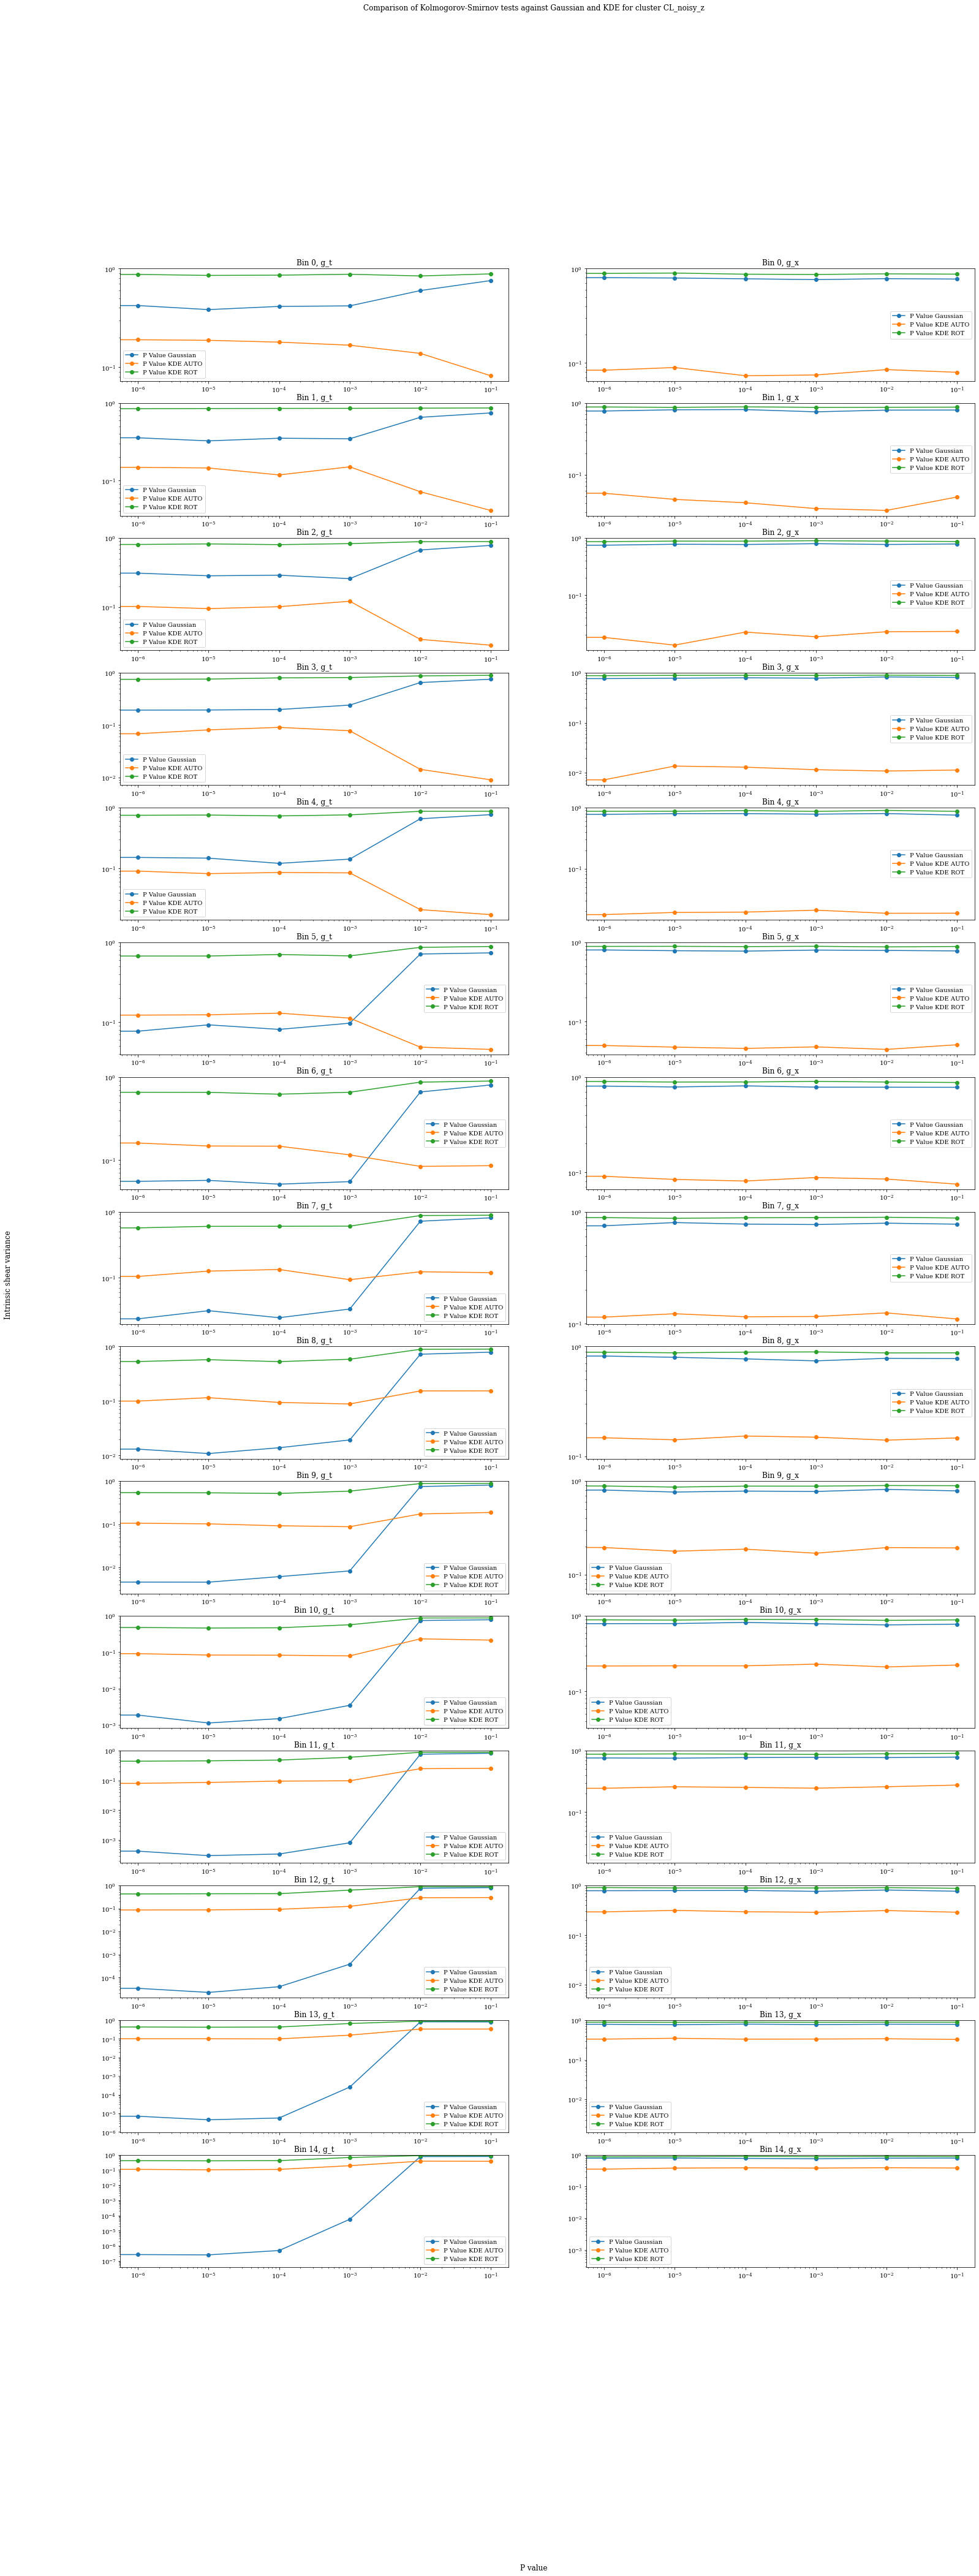

In [16]:
dim            = 25
new_shapenoise = [0] + shapenoise[1:]

fig, ax = plt.subplots(len(bins), 2, figsize=(dim,dim//6*len(bins)), facecolor="white")
fig.suptitle(f'Comparison of Kolmogorov-Smirnov tests against Gaussian and KDE for cluster {cluster[0]}')
fig.supxlabel(f'P value')
fig.supylabel(f'Intrinsic shear variance')

try:
    for i in range(len(bins)):

        ax[i][0].plot(new_shapenoise, p_value_gaussian_gt[i,:], marker='o', linestyle='-', label='P Value Gaussian')
        ax[i][0].plot(new_shapenoise, p_value_kde_auto_gt[i,:], marker='o', linestyle='-', label='P Value KDE AUTO')
        ax[i][0].plot(new_shapenoise, p_value_kde_rot_gt[i,:], marker='o', linestyle='-', label='P Value KDE ROT')
        ax[i][0].set_title(f'Bin {bins[i]}, g_t')
        ax[i][0].set_xscale('log')
        ax[i][0].set_yscale('log')
        ax[i][0].set_ylim(0,1)
        ax[i][0].legend()

        ax[i][1].plot(new_shapenoise, p_value_gaussian_gx[i,:], marker='o', linestyle='-', label='P Value Gaussian')
        ax[i][1].plot(new_shapenoise, p_value_kde_auto_gx[i,:], marker='o', linestyle='-', label='P Value KDE AUTO')
        ax[i][1].plot(new_shapenoise, p_value_kde_rot_gx[i,:], marker='o', linestyle='-', label='P Value KDE ROT')
        ax[i][1].set_title(f'Bin {bins[i]}, g_x')
        ax[i][1].set_xscale('log')
        ax[i][1].set_yscale('log')
        ax[i][1].set_ylim(0,1)
        ax[i][1].legend()
except:

    ax[0].plot(new_shapenoise, p_value_gaussian_gt[i,:], marker='o', linestyle='-', label='P Value Gaussian')
    ax[0].plot(new_shapenoise, p_value_kde_auto_gt[i,:], marker='o', linestyle='-', label='P Value KDE AUTO')
    ax[0].plot(new_shapenoise, p_value_kde_rot_gt[i,:], marker='o', linestyle='-', label='P Value KDE ROT')
    ax[0].set_title(f'Bin {bins[0]}, g_t')
    ax[0].set_xscale('log')
    ax[0].set_ylim(0,1)
    ax[0].legend()

    ax[1].plot(new_shapenoise, p_value_gaussian_gx[i,:], marker='o', linestyle='-', label='P Value Gaussian')
    ax[1].plot(new_shapenoise, p_value_kde_auto_gx[i,:], marker='o', linestyle='-', label='P Value KDE AUTO')
    ax[1].plot(new_shapenoise, p_value_kde_rot_gx[i,:], marker='o', linestyle='-', label='P Value KDE ROT')
    ax[1].set_title(f'Bin {bins[0]}, g_x')
    ax[1].set_xscale('log')
    ax[1].set_ylim(0,1)
    ax[1].legend()
